In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sqlalchemy import create_engine
import scipy.stats as stats


import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Load dataset

In [16]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [17]:
#allow us to see all columns and rows w/out truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Alright, load successful. Let's start doing some EDA and cleaning.

First, we'll work with missing values.

In [18]:
df.isnull().sum() / df.isnull().count() * 100

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
bsmtqual          2.534247
bsmtcond          2.534247
bsmtexposure      2.602740
bsmtfintype1      2.534247
bsmtfinsf1        0.000000
bsmtfintype2      2.602740
bsmtfinsf2        0.000000
b

Ok, there are some missing values. Some with alarmingly high values.

According to the text file with column descriptions, many of the categorical null values means that house does not have that feature. For example, alley null values means there is no alley access. Let's clean these up as well as filling in some null values for our others.

In [19]:
#fill in some missing values
df.lotfrontage.fillna(df.lotfrontage.median(), inplace=True)
#Alley NA's means there's no alley access
df.alley.fillna('No Access', inplace=True)
#basement NA's == no basement
df.bsmtqual.fillna('No Basement', inplace=True)
df.bsmtcond.fillna('No Basement', inplace=True)
df.bsmtexposure.fillna('No Basement', inplace=True)
df.bsmtfintype1.fillna('No Basement', inplace=True)
df.bsmtfintype2.fillna('No Basement', inplace=True)
#fireplace na means no fireplace
df.fireplacequ.fillna('No Fireplace', inplace=True)
#garage--see above
df.garagetype.fillna('No Garage', inplace=True)
df.garagefinish.fillna('No Garage', inplace=True)
df.garagequal.fillna('No Garage', inplace=True)
df.garagecond.fillna('No Garage', inplace=True)
df.garageyrblt.fillna('No Year', inplace=True)
#these are unique, but same as above
df.poolqc.fillna('No pool', inplace=True)
df.fence.fillna('No Fence', inplace=True)
df.miscfeature.fillna('None unique', inplace=True)
#masonry is either 0 or not there
df.masvnrtype.fillna('No masonry', inplace=True)
df.masvnrarea.fillna(0, inplace=True)

In [20]:
df.isnull().sum() / df.isnull().count() * 100

id               0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.000000
lotarea          0.000000
street           0.000000
alley            0.000000
lotshape         0.000000
landcontour      0.000000
utilities        0.000000
lotconfig        0.000000
landslope        0.000000
neighborhood     0.000000
condition1       0.000000
condition2       0.000000
bldgtype         0.000000
housestyle       0.000000
overallqual      0.000000
overallcond      0.000000
yearbuilt        0.000000
yearremodadd     0.000000
roofstyle        0.000000
roofmatl         0.000000
exterior1st      0.000000
exterior2nd      0.000000
masvnrtype       0.000000
masvnrarea       0.000000
exterqual        0.000000
extercond        0.000000
foundation       0.000000
bsmtqual         0.000000
bsmtcond         0.000000
bsmtexposure     0.000000
bsmtfintype1     0.000000
bsmtfinsf1       0.000000
bsmtfintype2     0.000000
bsmtfinsf2       0.000000
bsmtunfsf        0.000000
totalbsmtsf 

Now that we've handled almost all missing values, let's explore the data with some univariate analysis.

In [21]:
columns = df.columns.tolist()
columns.remove('id')

In [22]:
for column in columns:
    print('{} -- {}'.format(column, df[column].nunique()))

mssubclass -- 15
mszoning -- 5
lotfrontage -- 110
lotarea -- 1073
street -- 2
alley -- 3
lotshape -- 4
landcontour -- 4
utilities -- 2
lotconfig -- 5
landslope -- 3
neighborhood -- 25
condition1 -- 9
condition2 -- 8
bldgtype -- 5
housestyle -- 8
overallqual -- 10
overallcond -- 9
yearbuilt -- 112
yearremodadd -- 61
roofstyle -- 6
roofmatl -- 8
exterior1st -- 15
exterior2nd -- 16
masvnrtype -- 5
masvnrarea -- 327
exterqual -- 4
extercond -- 5
foundation -- 6
bsmtqual -- 5
bsmtcond -- 5
bsmtexposure -- 5
bsmtfintype1 -- 7
bsmtfinsf1 -- 637
bsmtfintype2 -- 7
bsmtfinsf2 -- 144
bsmtunfsf -- 780
totalbsmtsf -- 721
heating -- 6
heatingqc -- 5
centralair -- 2
electrical -- 5
firstflrsf -- 753
secondflrsf -- 417
lowqualfinsf -- 24
grlivarea -- 861
bsmtfullbath -- 4
bsmthalfbath -- 3
fullbath -- 4
halfbath -- 3
bedroomabvgr -- 8
kitchenabvgr -- 4
kitchenqual -- 4
totrmsabvgrd -- 12
functional -- 7
fireplaces -- 4
fireplacequ -- 6
garagetype -- 7
garageyrblt -- 98
garagefinish -- 4
garagecars -- 

Ok, we have a decent mix of categorical and continuous variables. To do thorough analysis, we'll need to split these apart.

In [23]:
#split our variables into continuous and categorical/discrete columns
cat_cols = []
cont_cols = []

for column in columns:
    #our categorical columns don't have many unique values, or don't start with a year
    if (column[:4] != 'year' and df[column].nunique() < 100):
        cat_cols.append(column)
    else:
        cont_cols.append(column)     

#some minor changes from our for loop logic above
cat_cols.remove('screenporch')
cont_cols.append('screenporch')
cat_cols.remove('garageyrblt')

Good. Let's visualize our categorical columns. Ideally, we want to find features with a decent mix of counts and unique values when compared with our target.

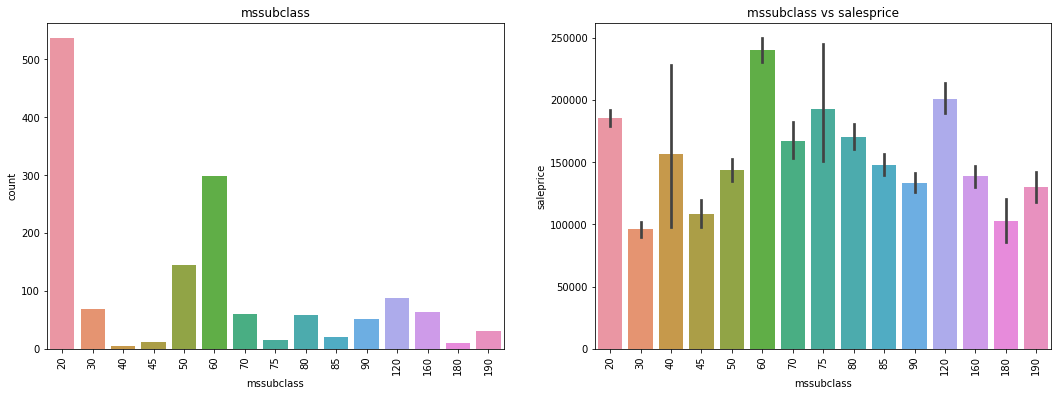

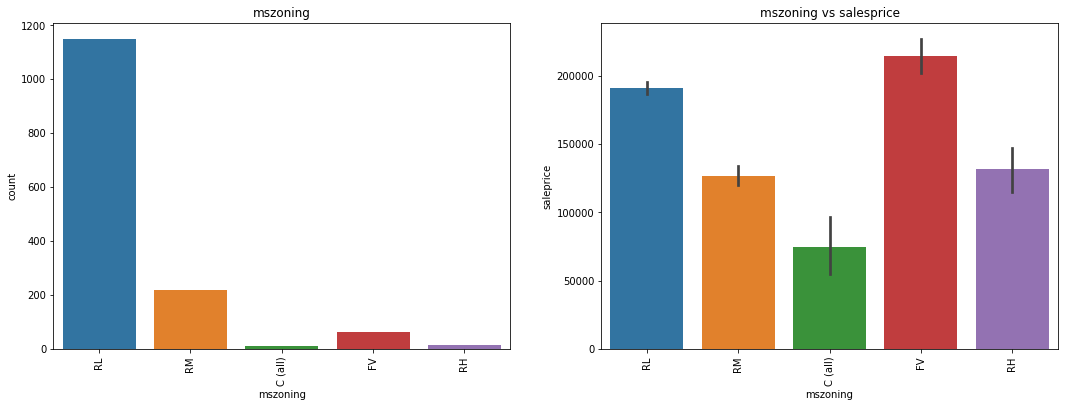

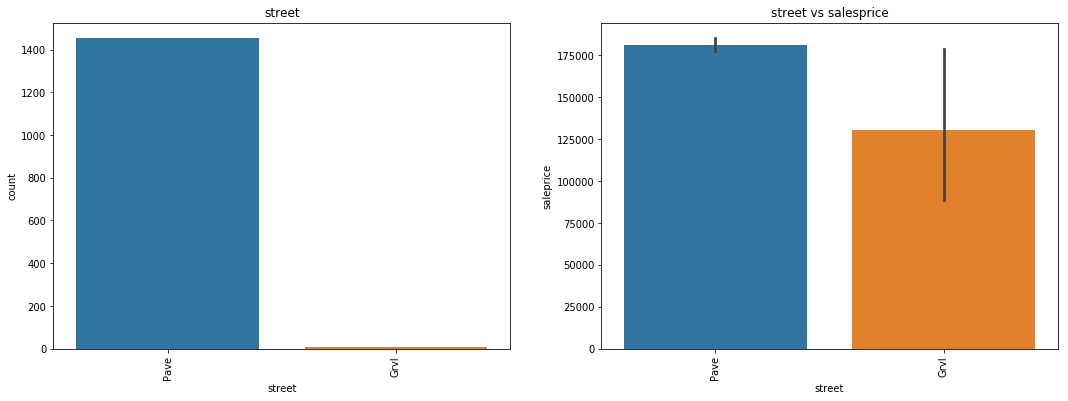

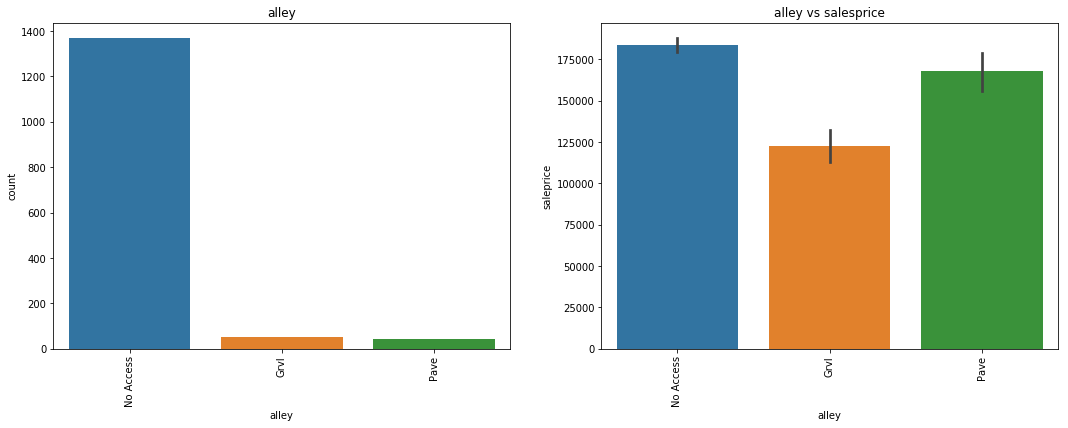

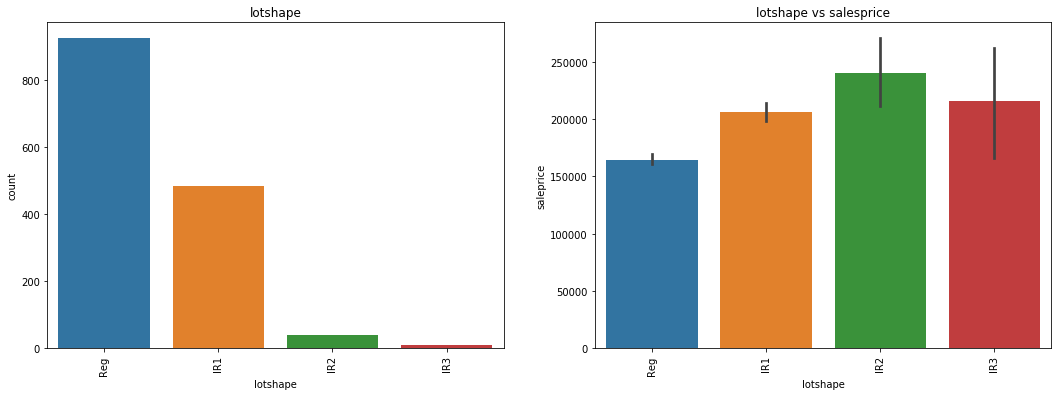

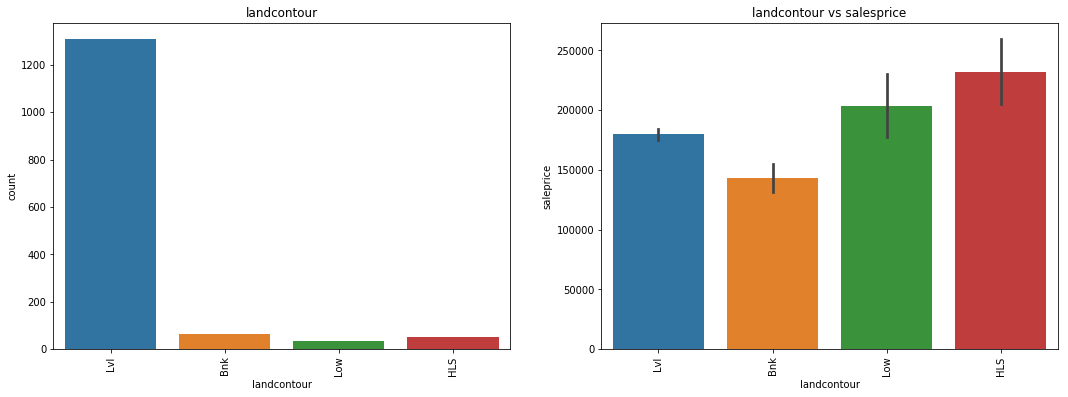

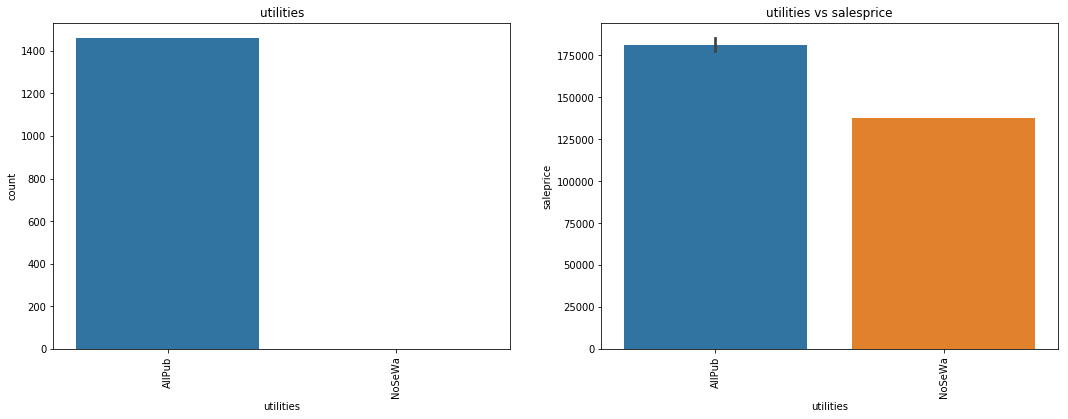

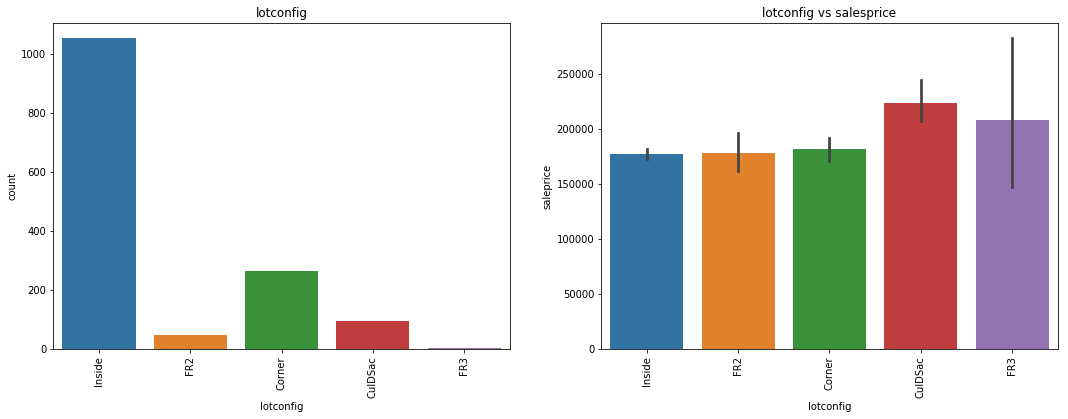

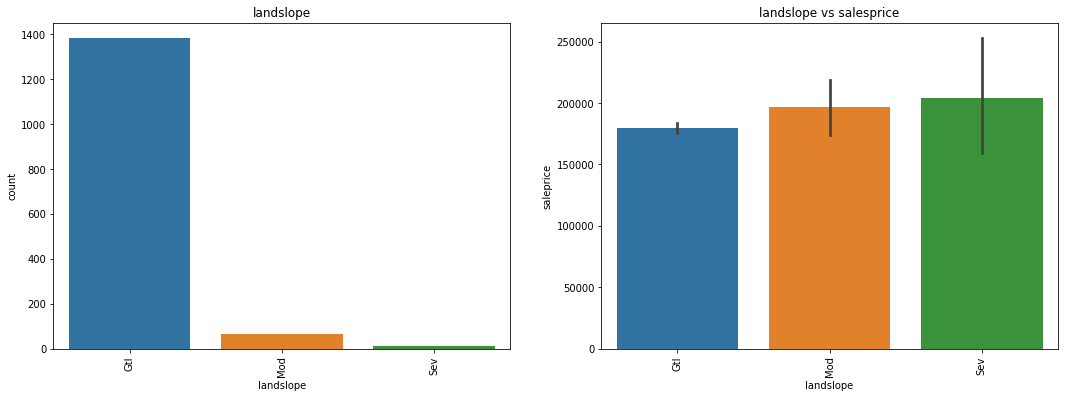

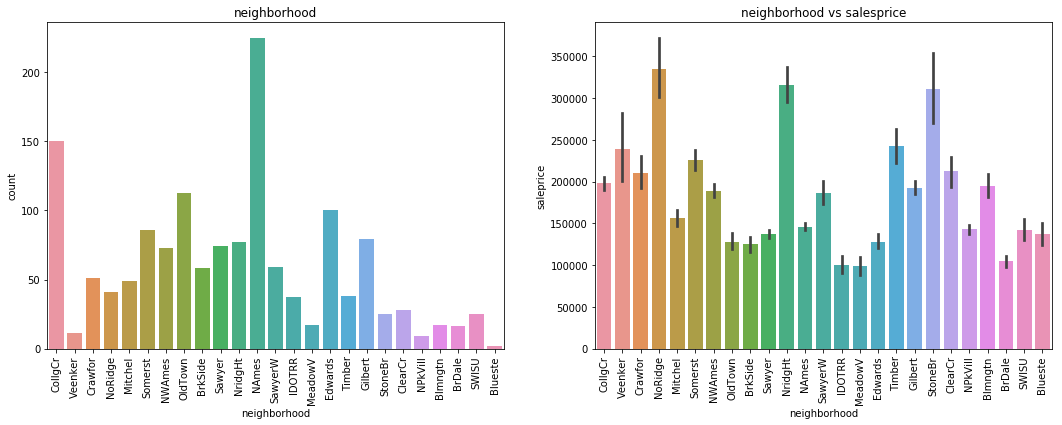

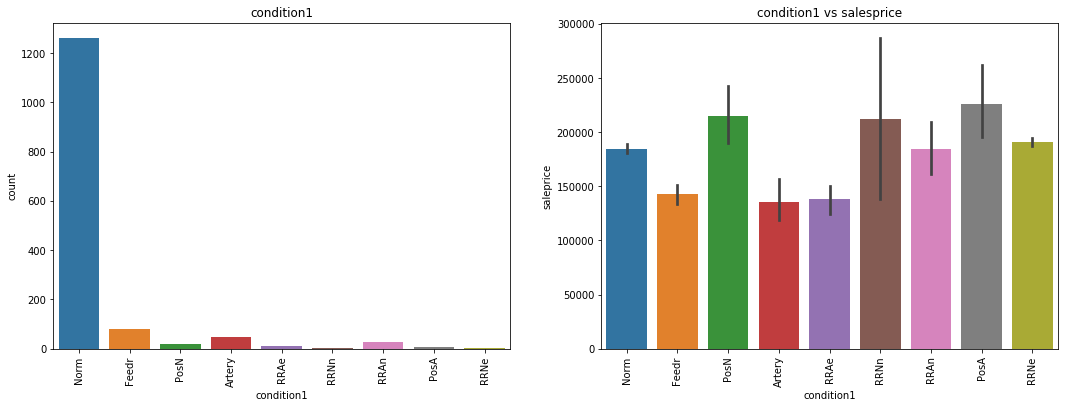

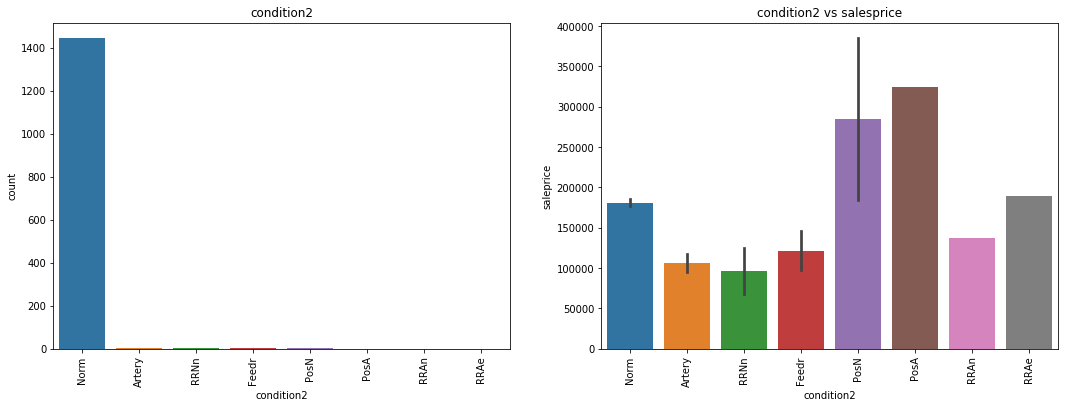

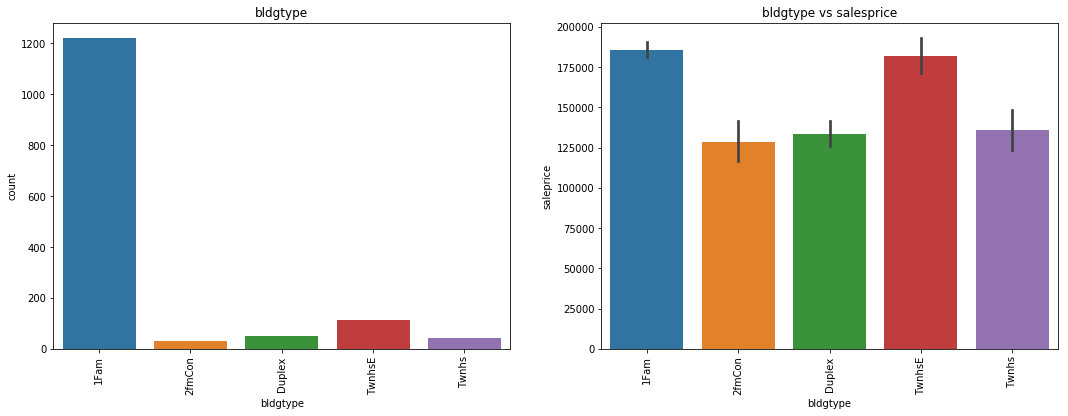

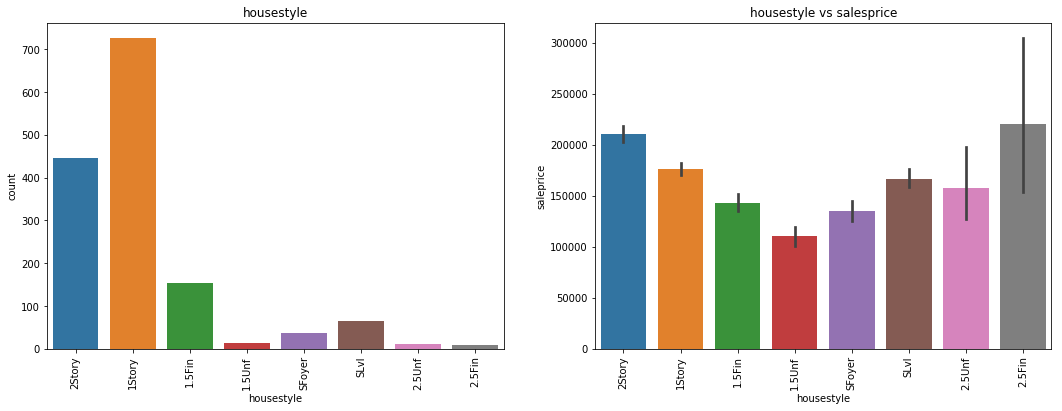

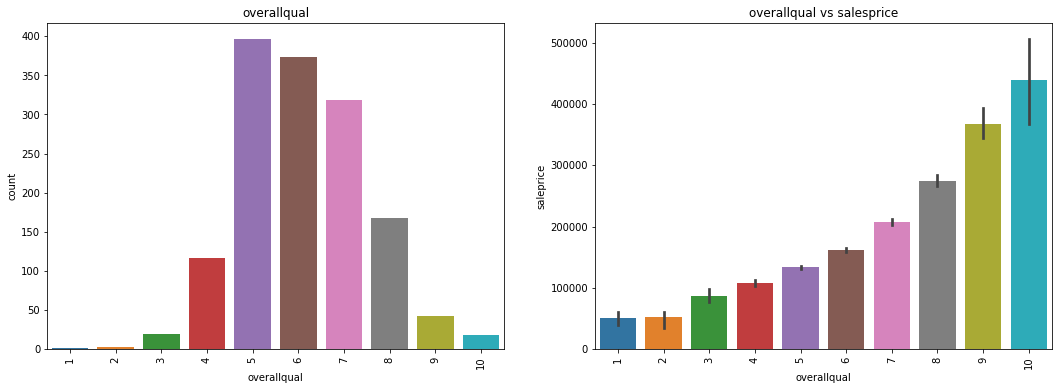

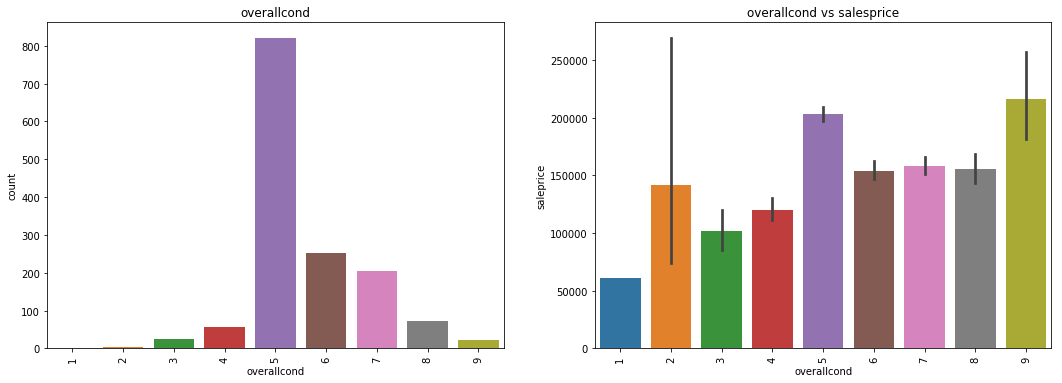

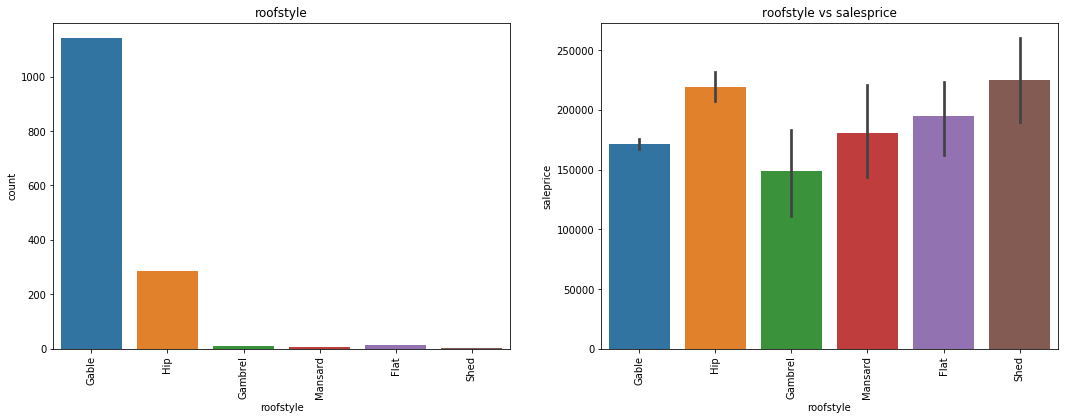

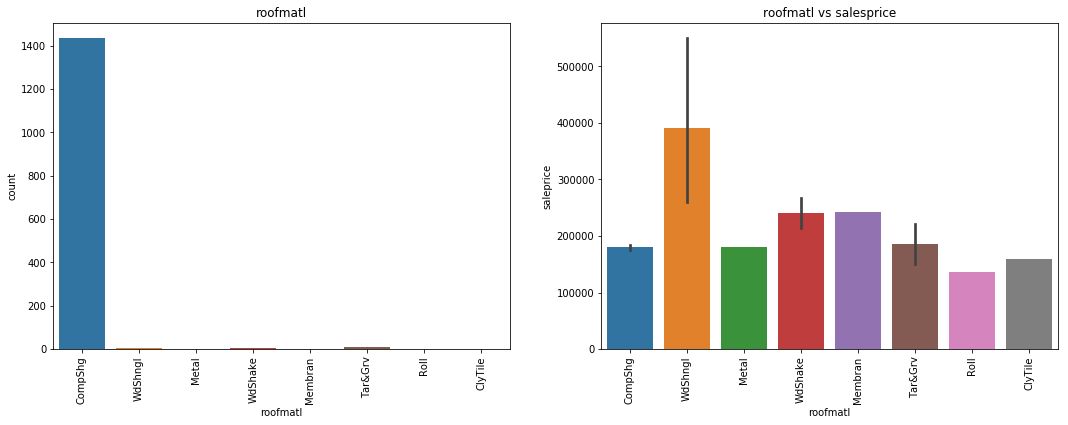

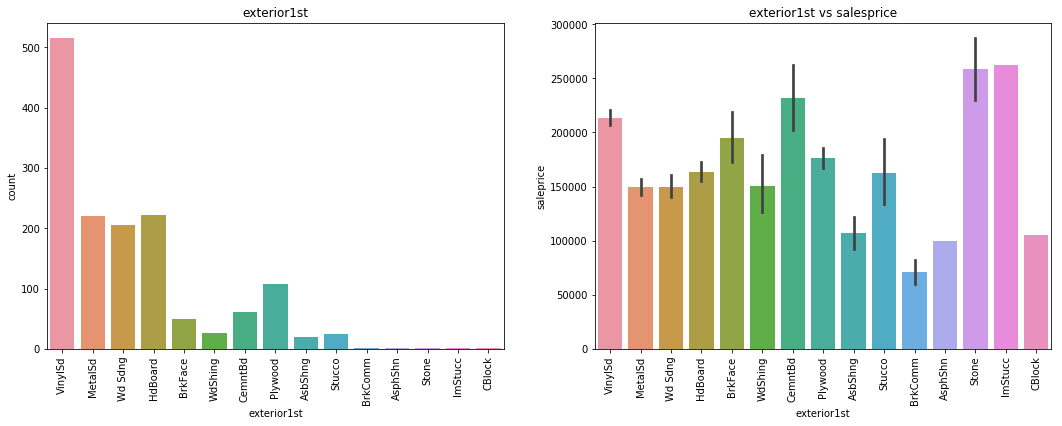

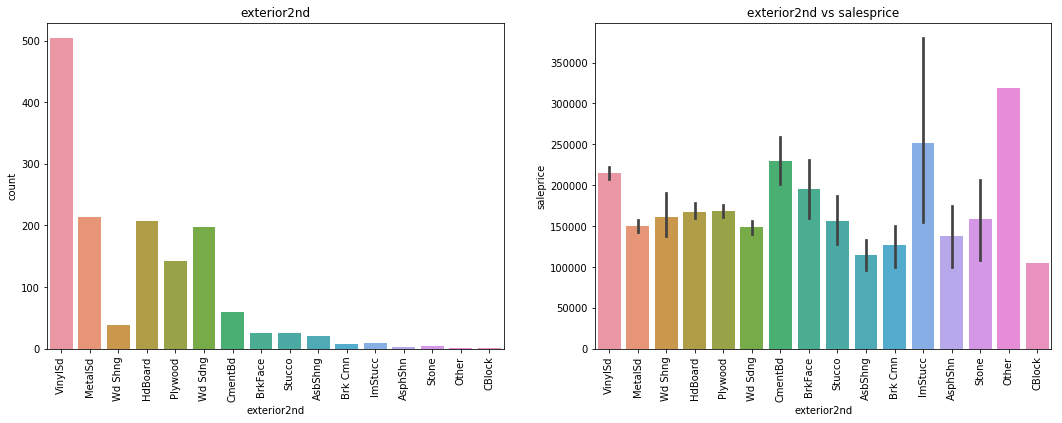

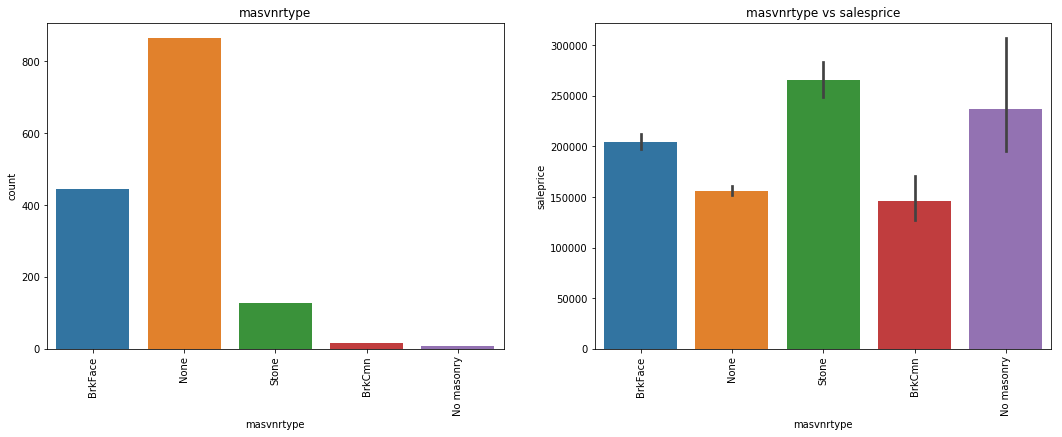

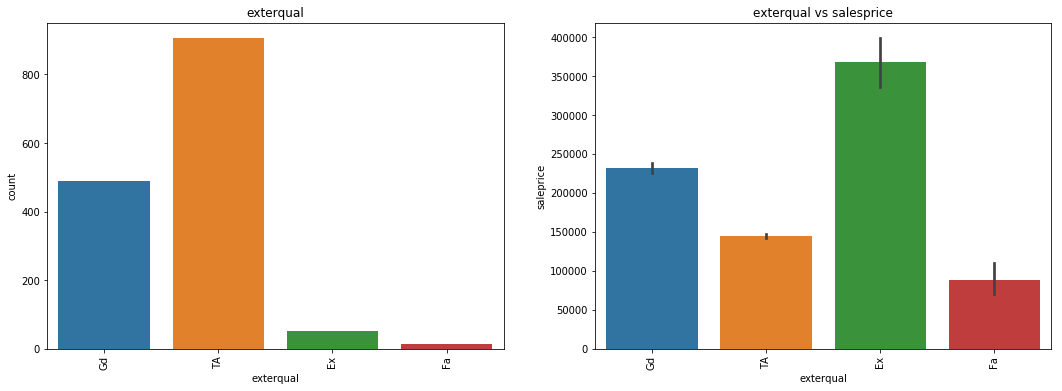

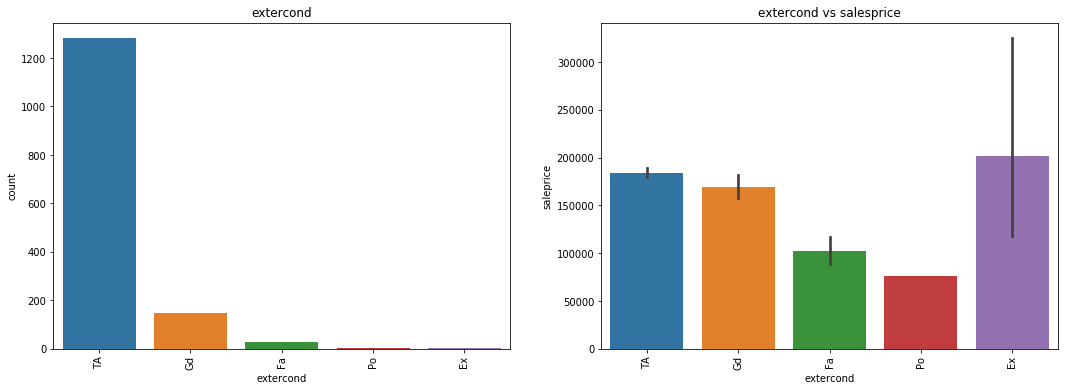

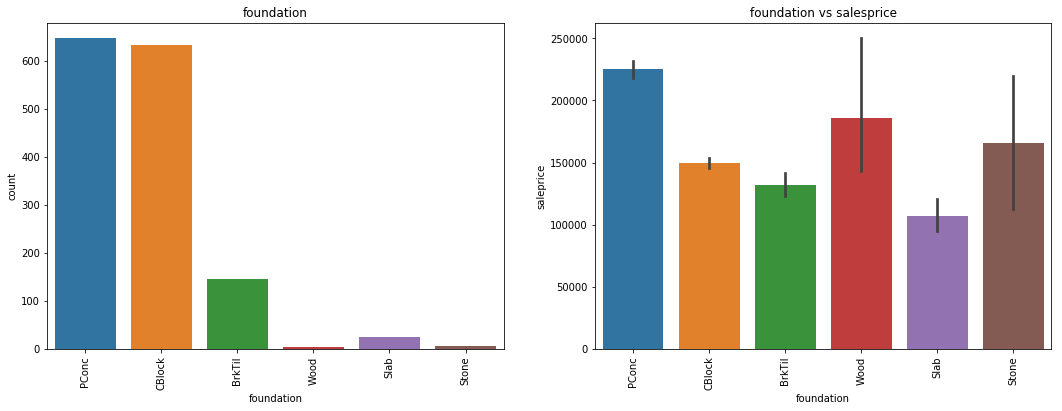

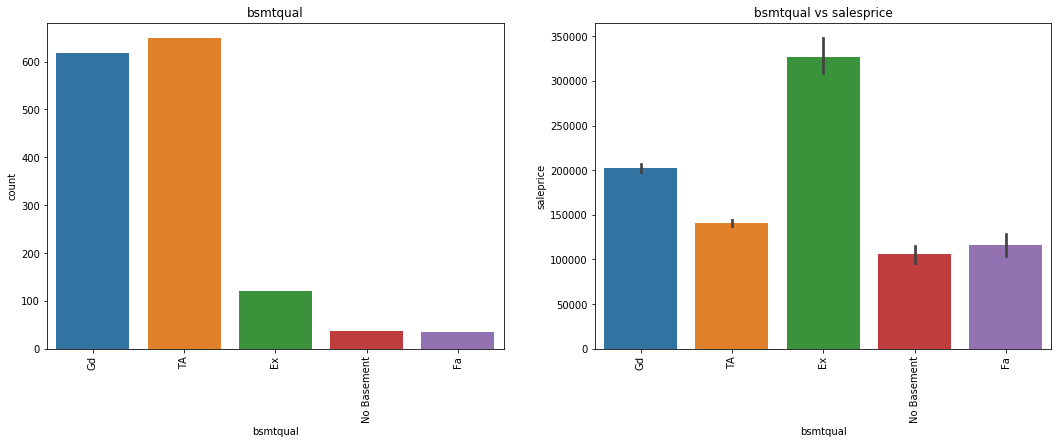

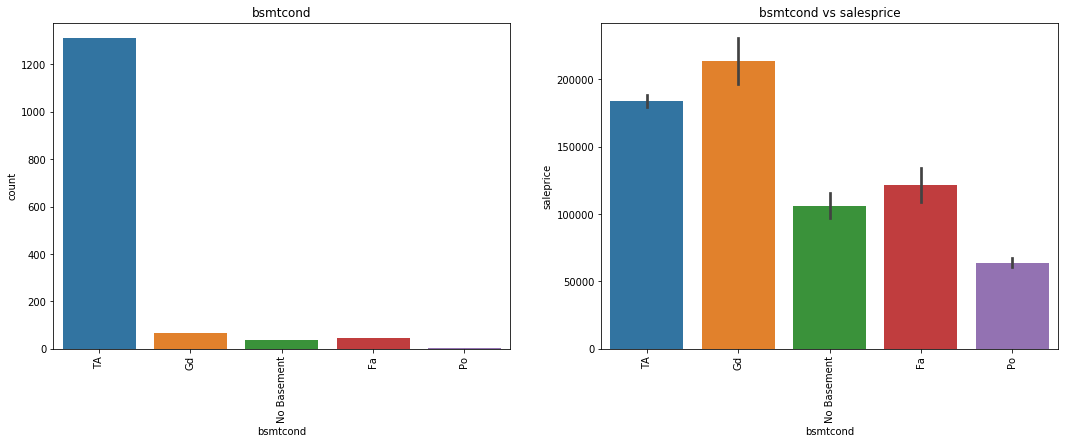

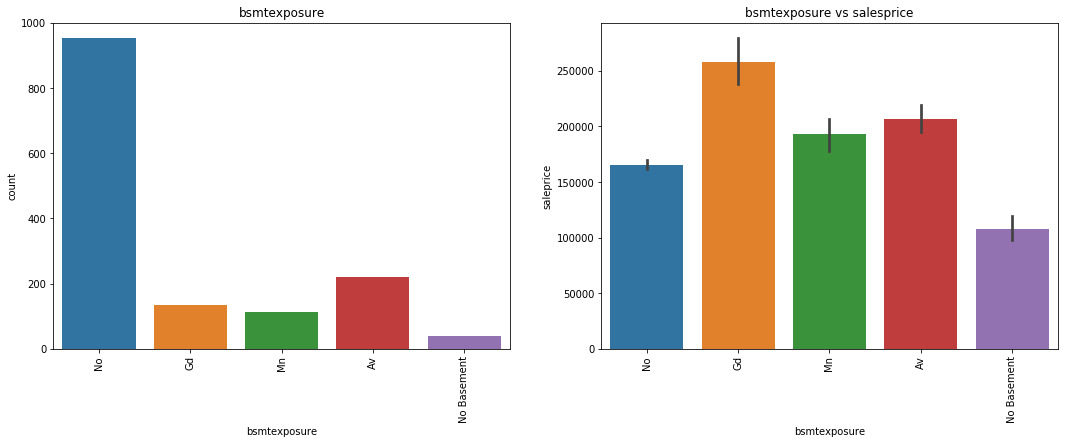

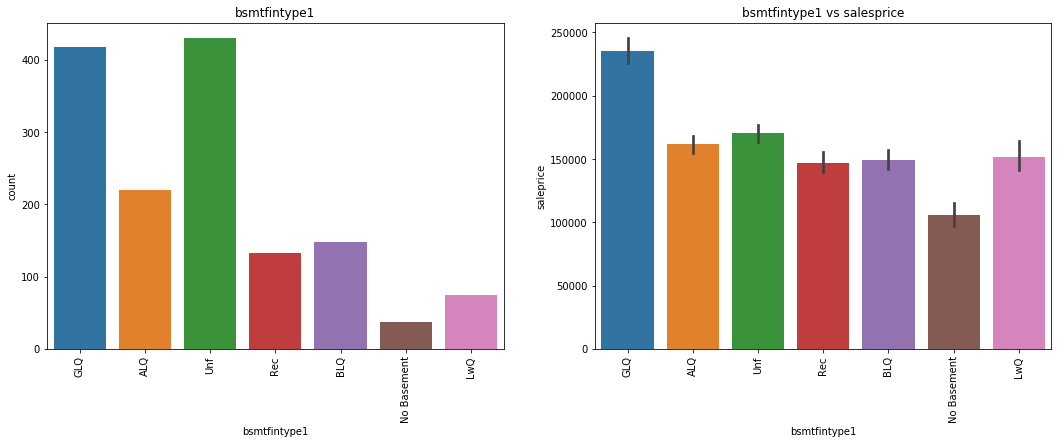

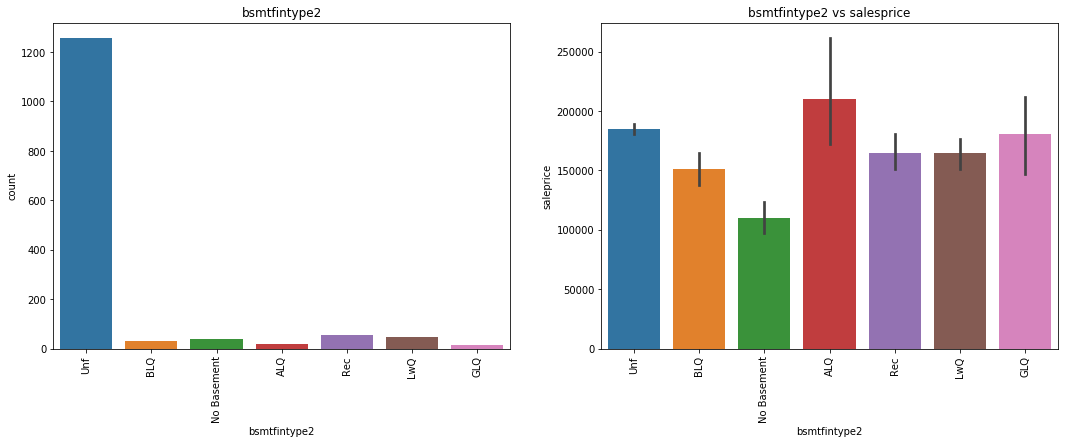

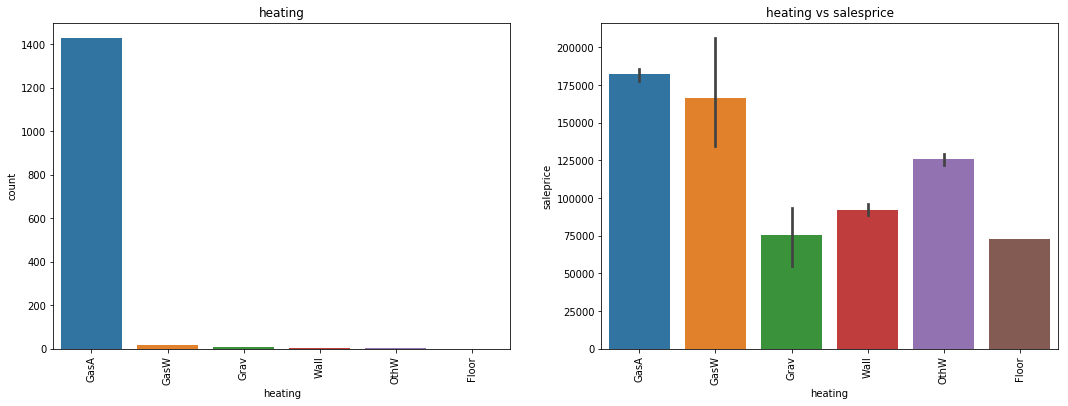

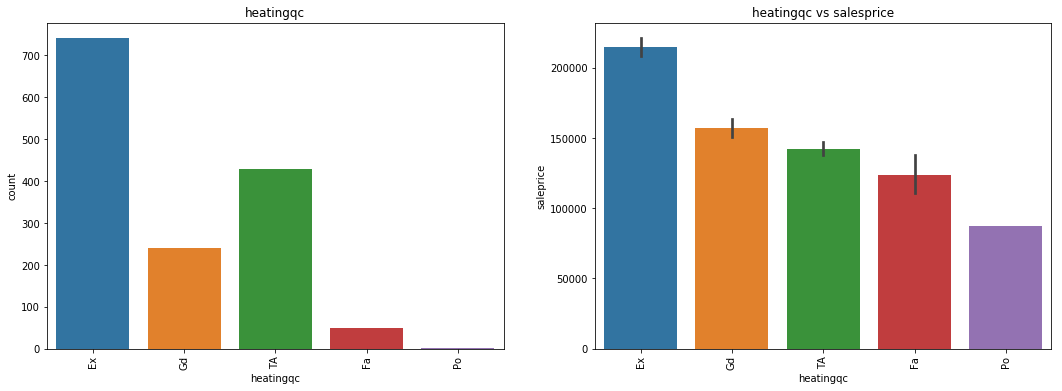

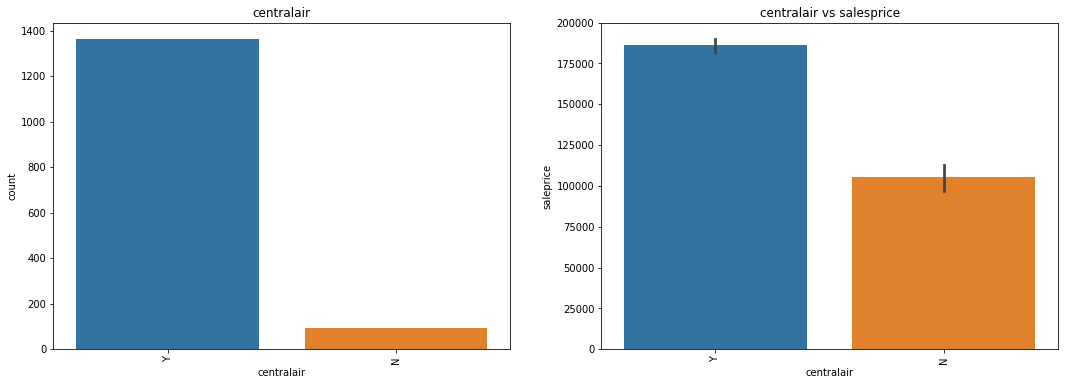

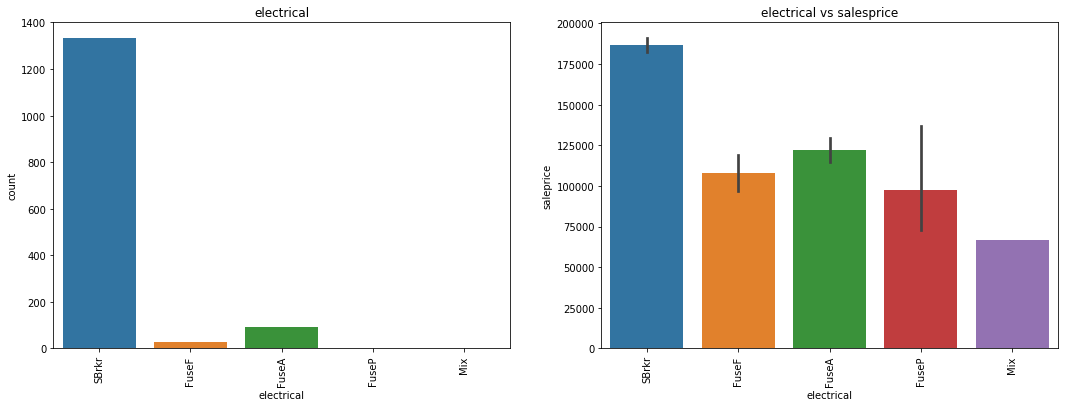

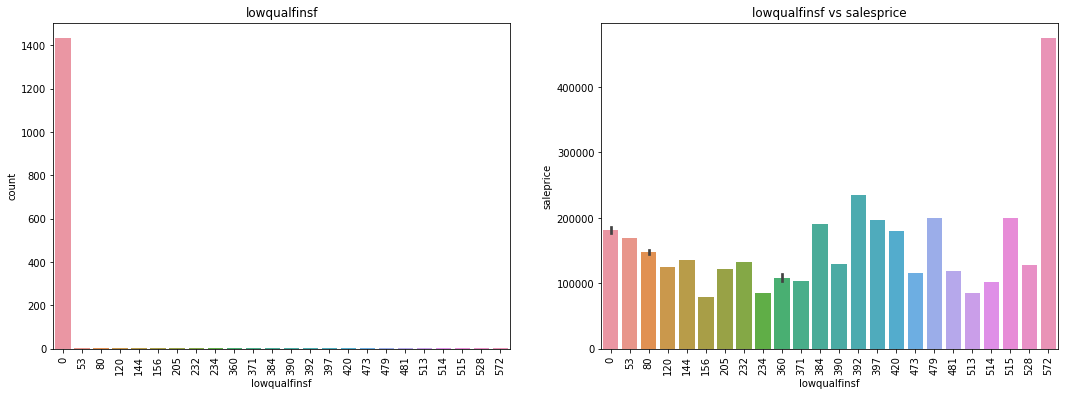

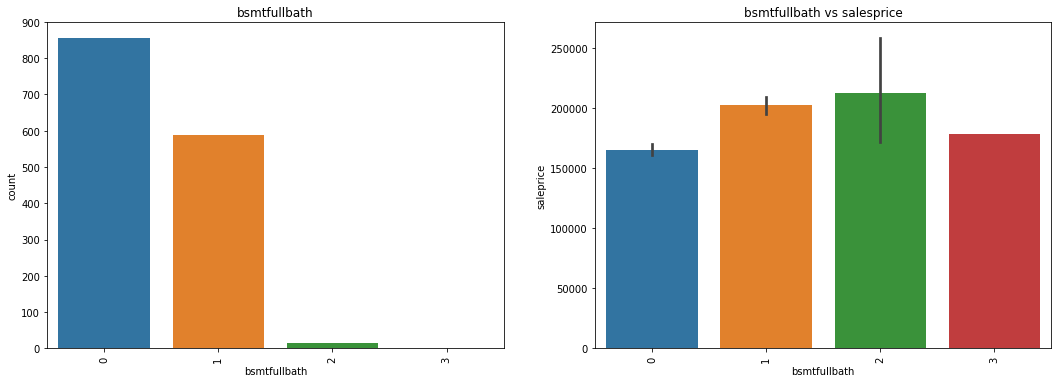

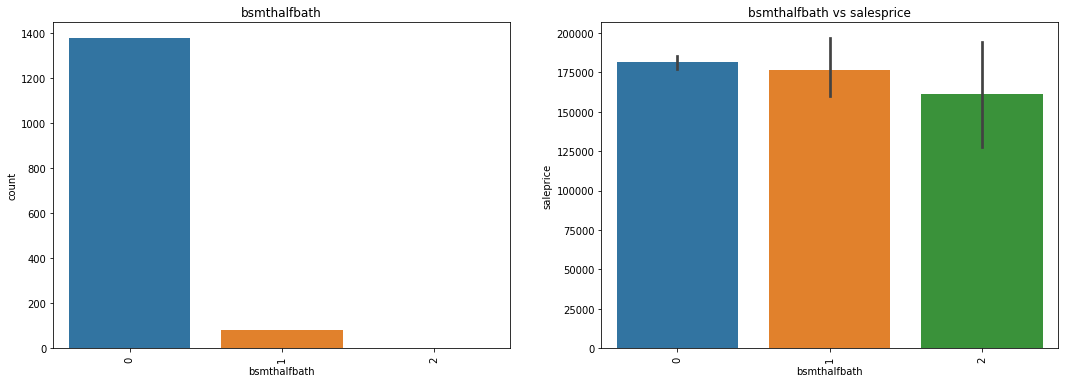

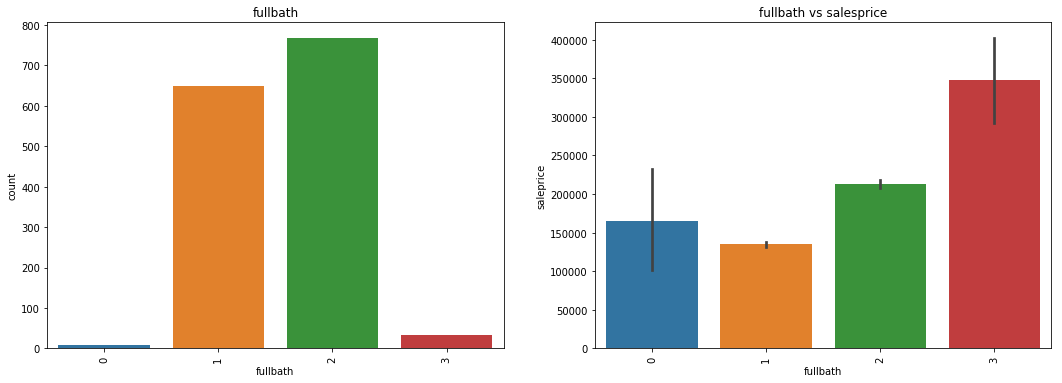

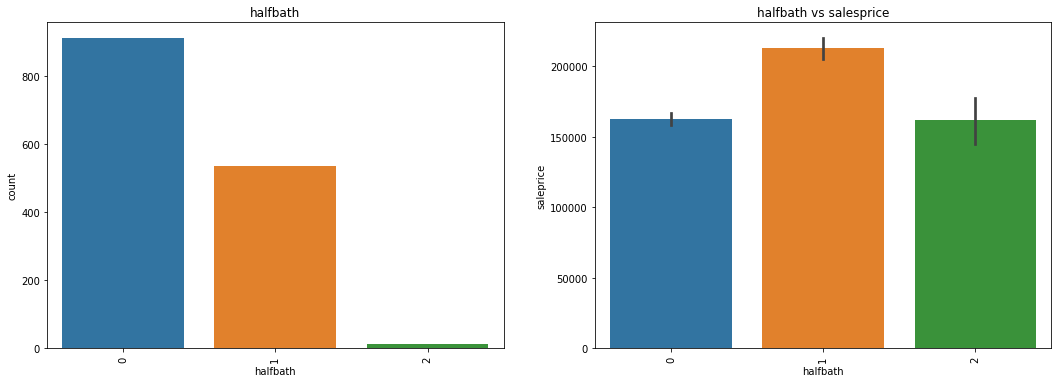

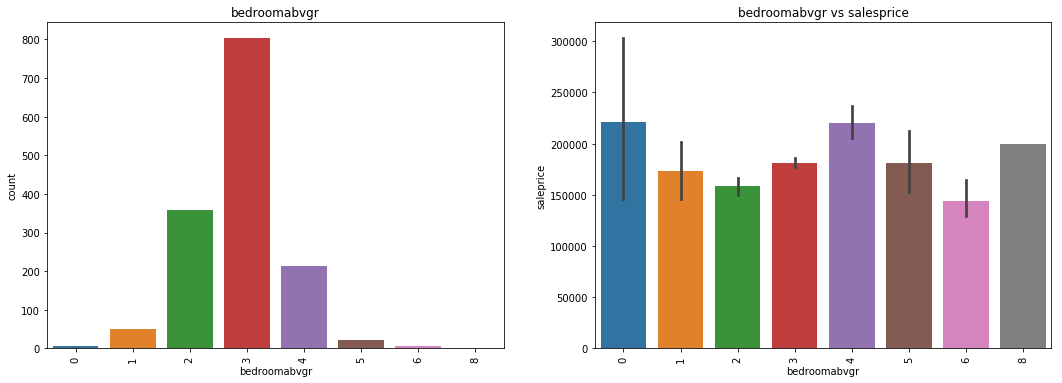

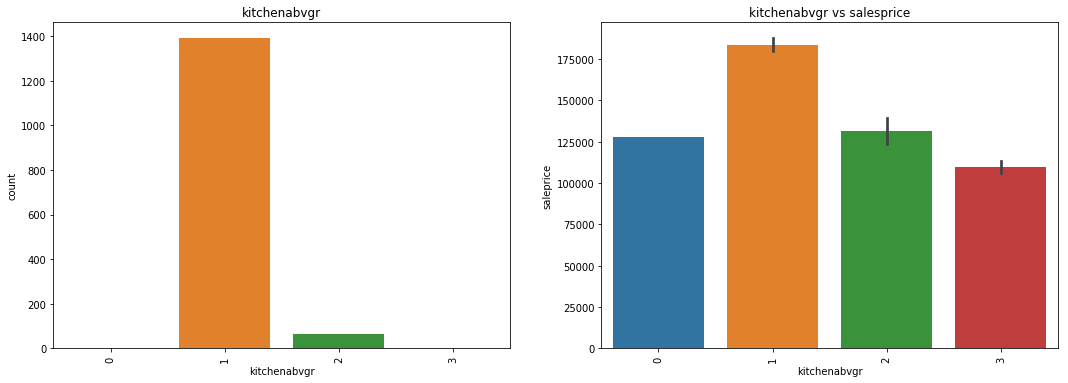

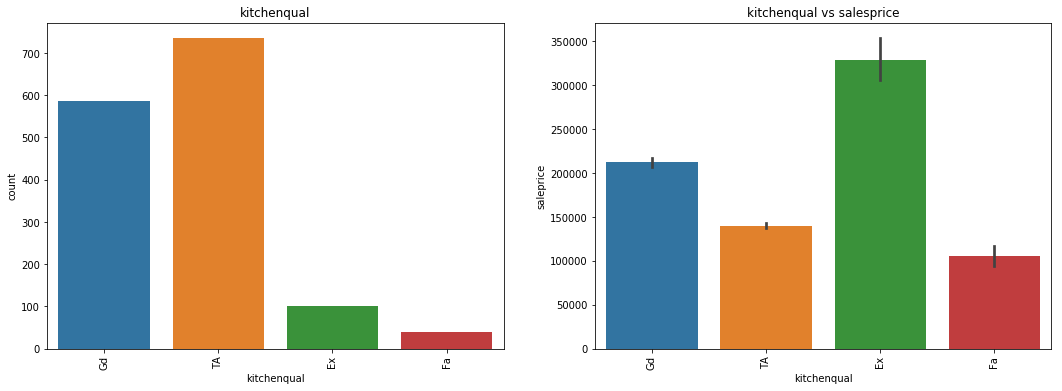

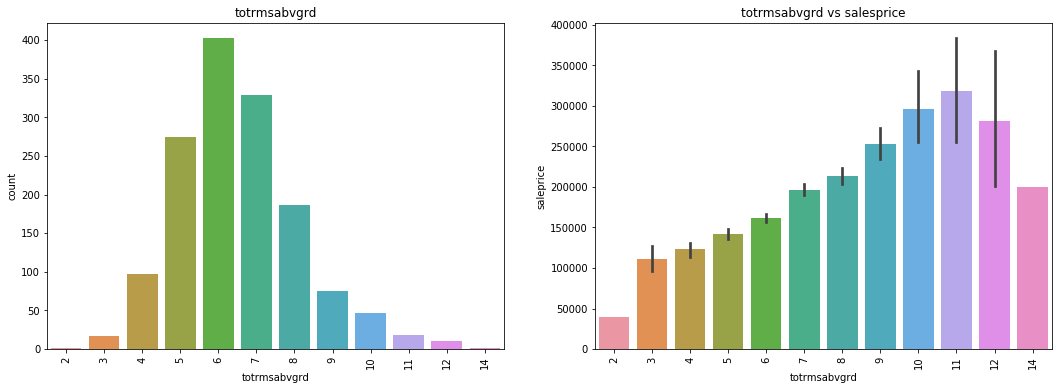

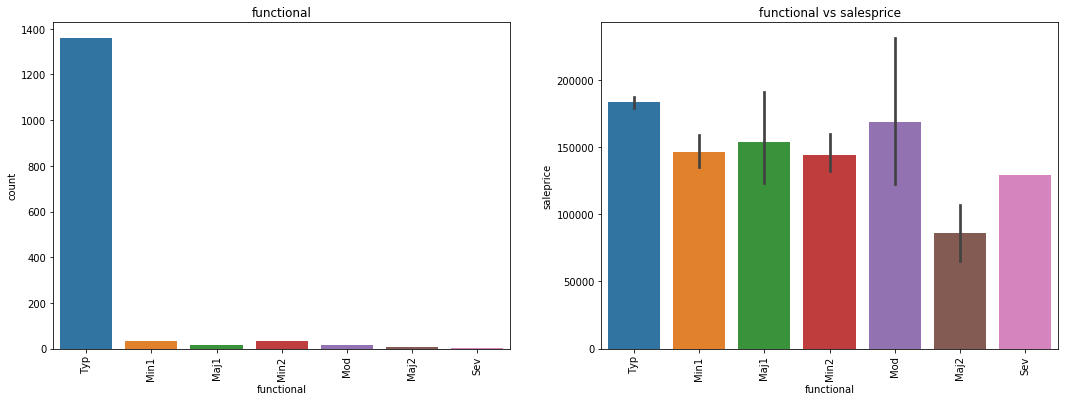

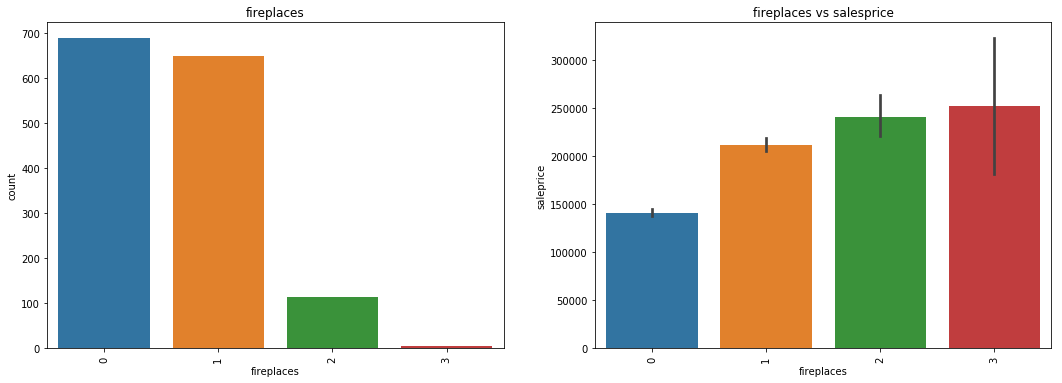

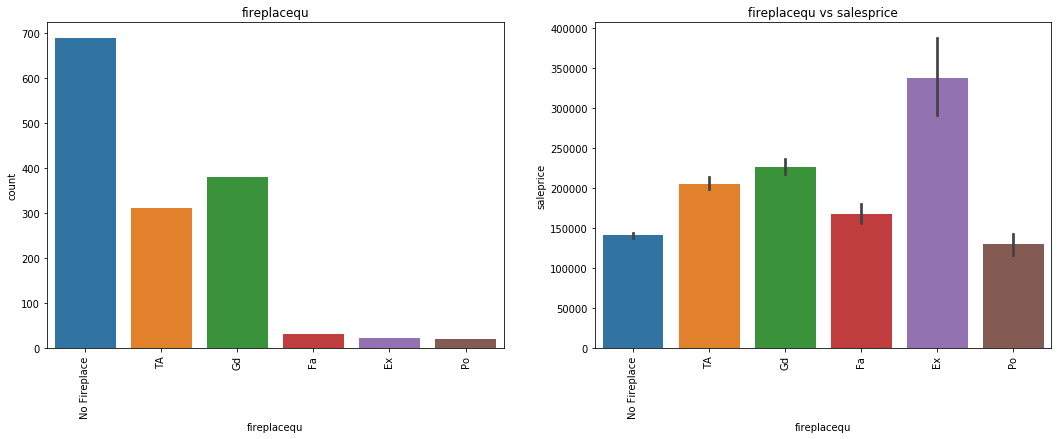

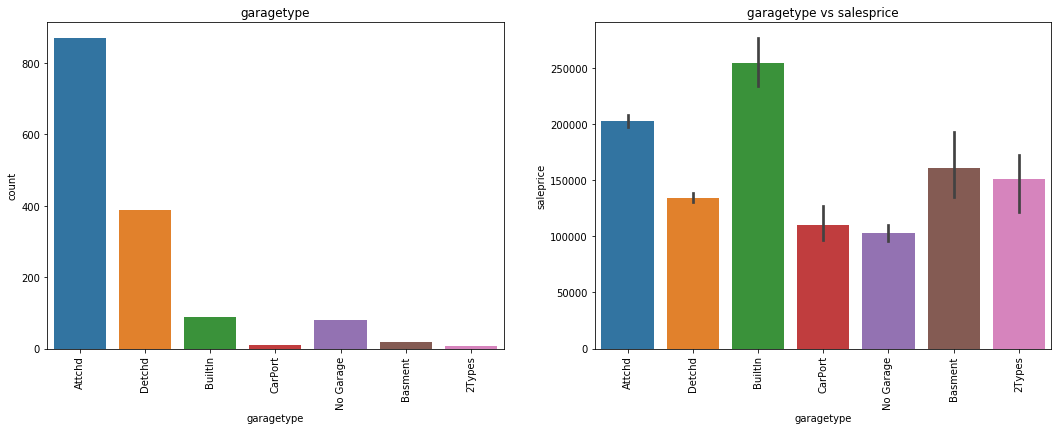

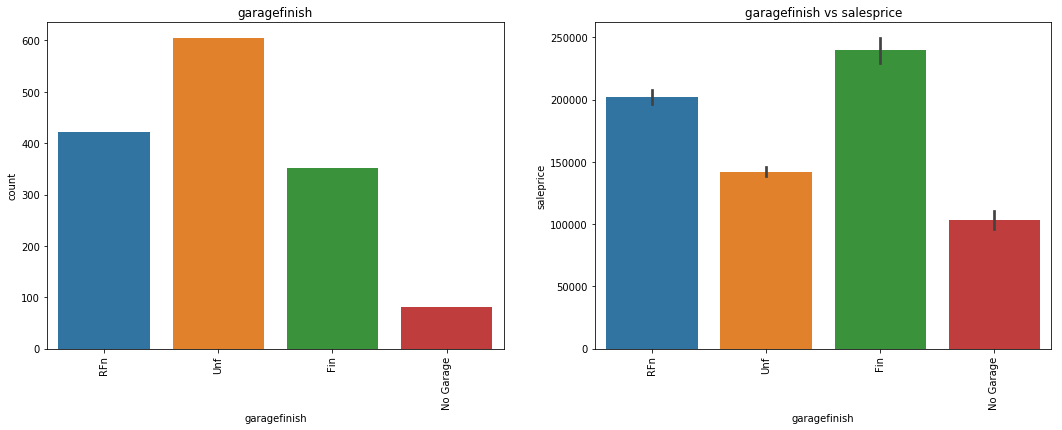

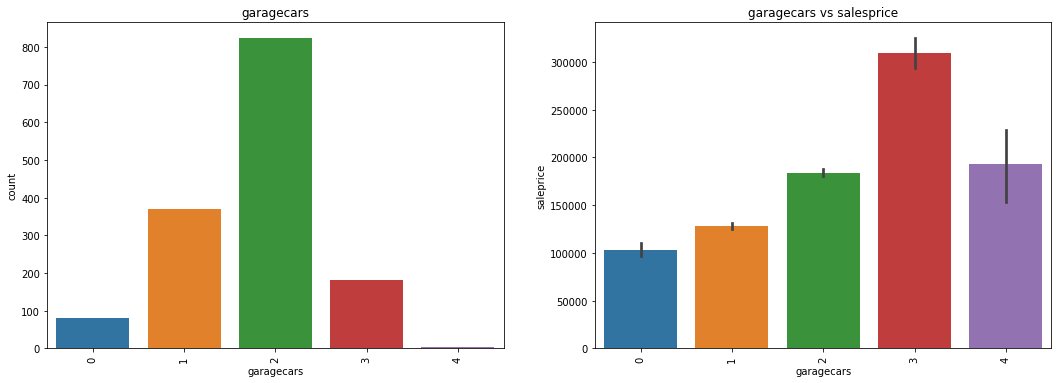

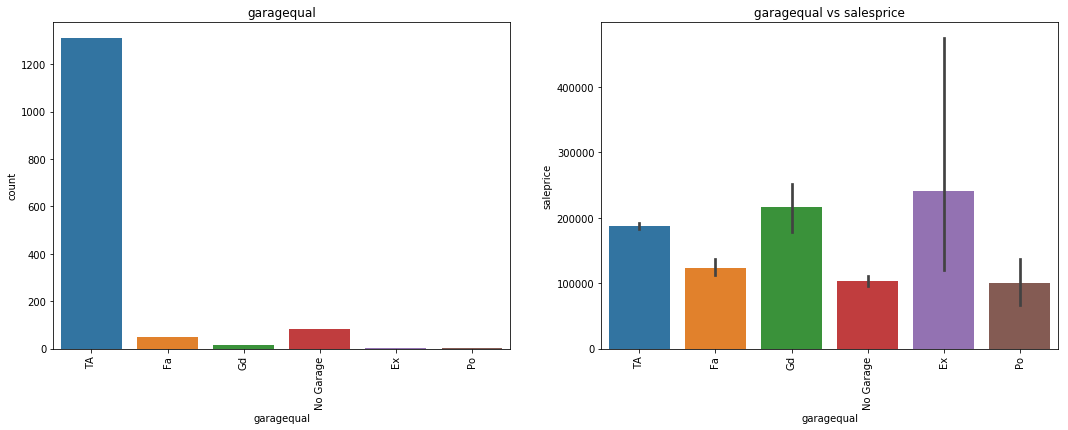

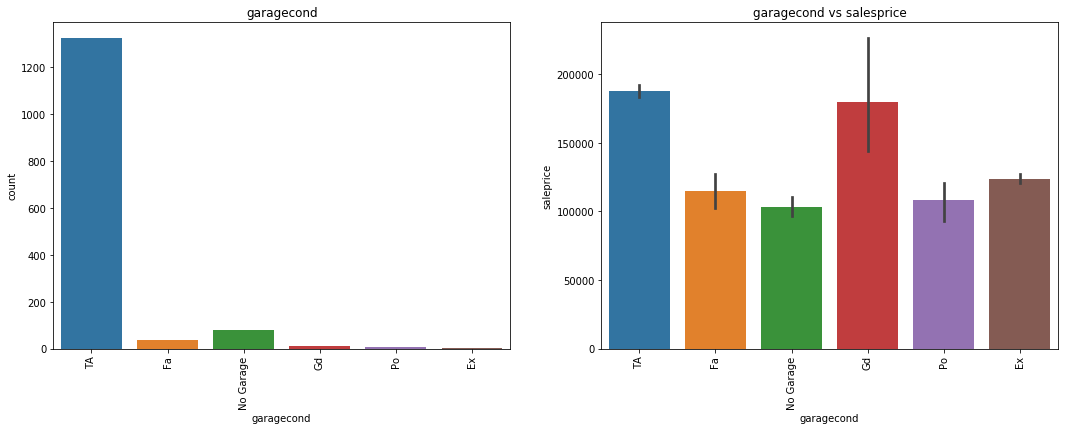

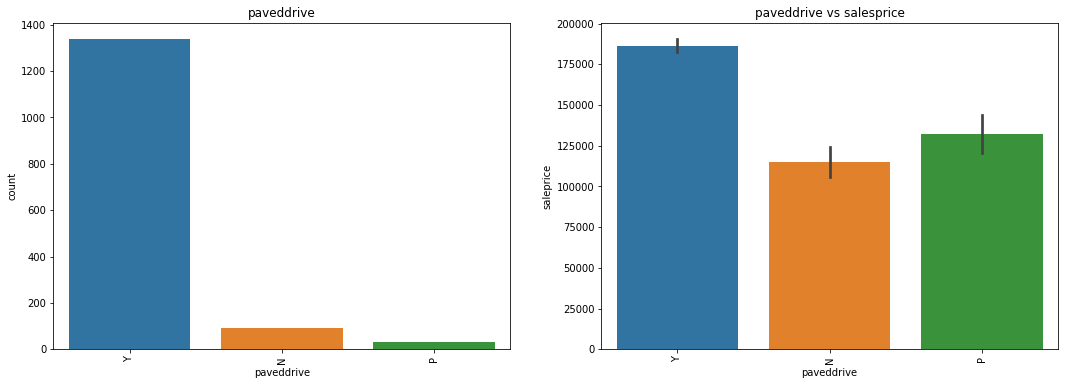

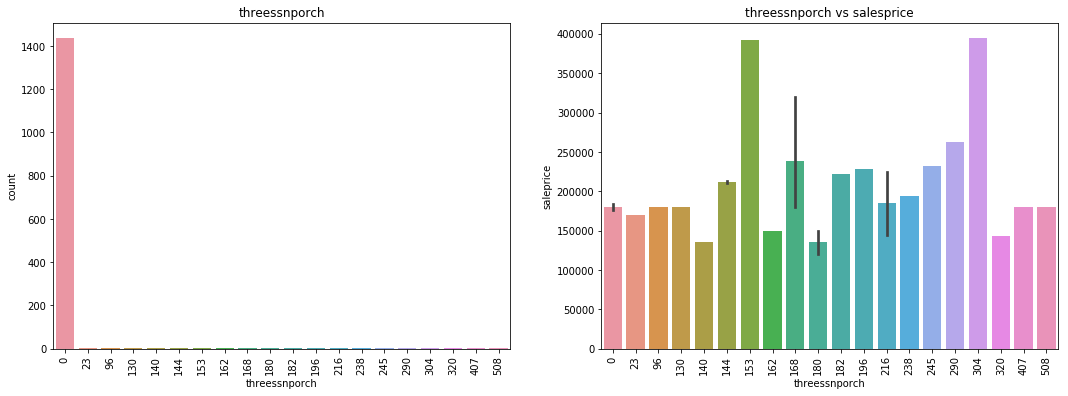

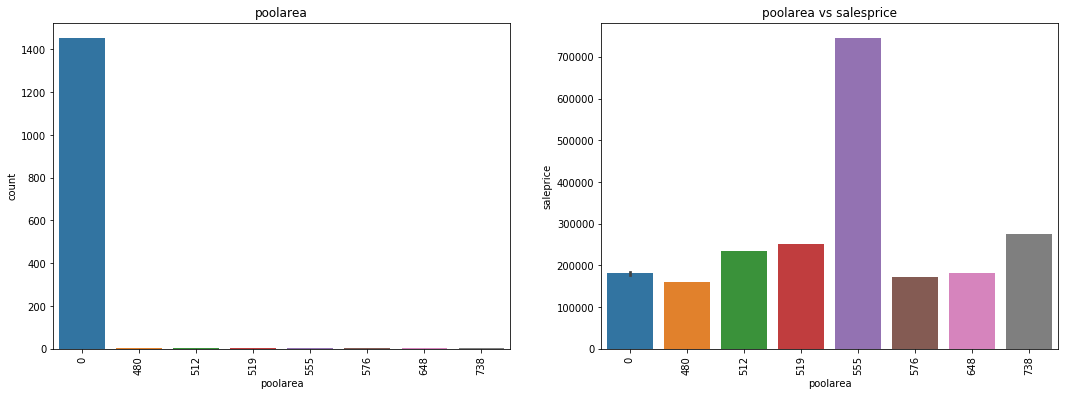

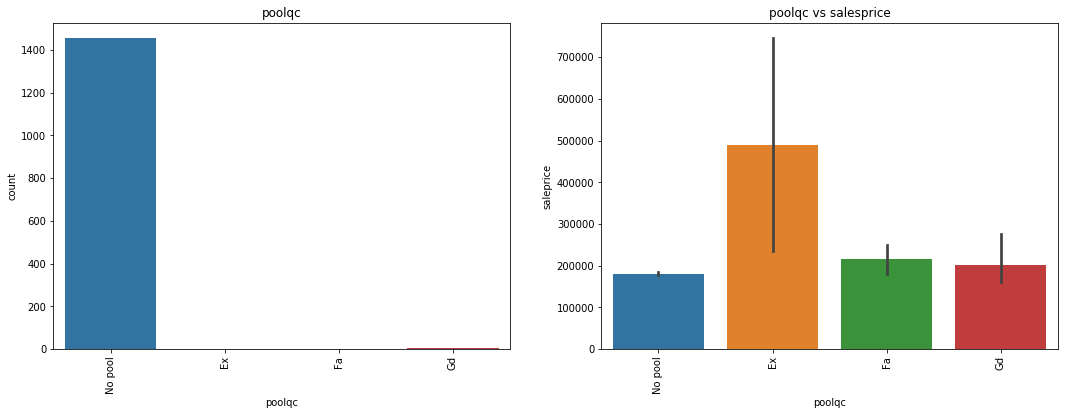

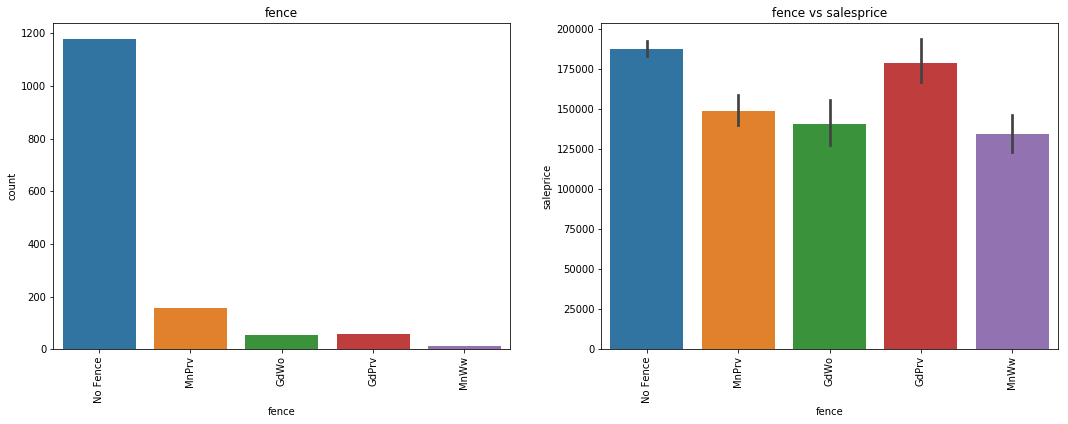

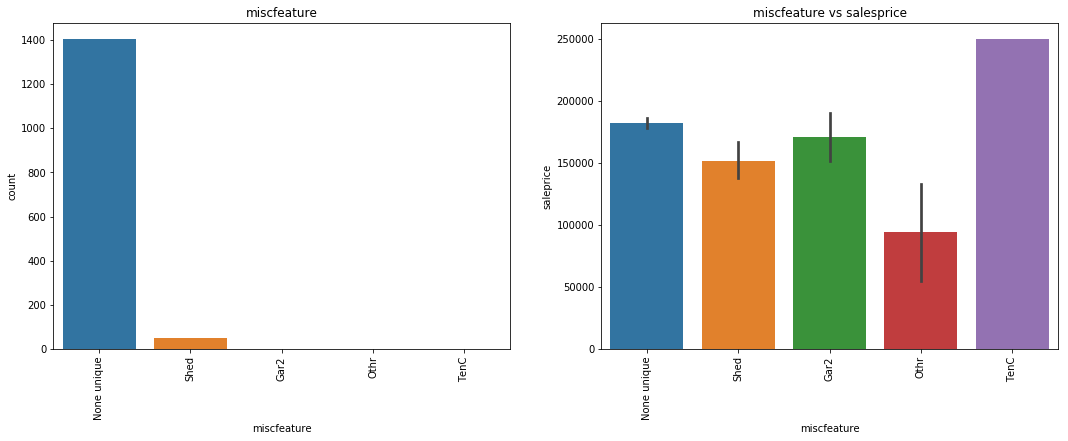

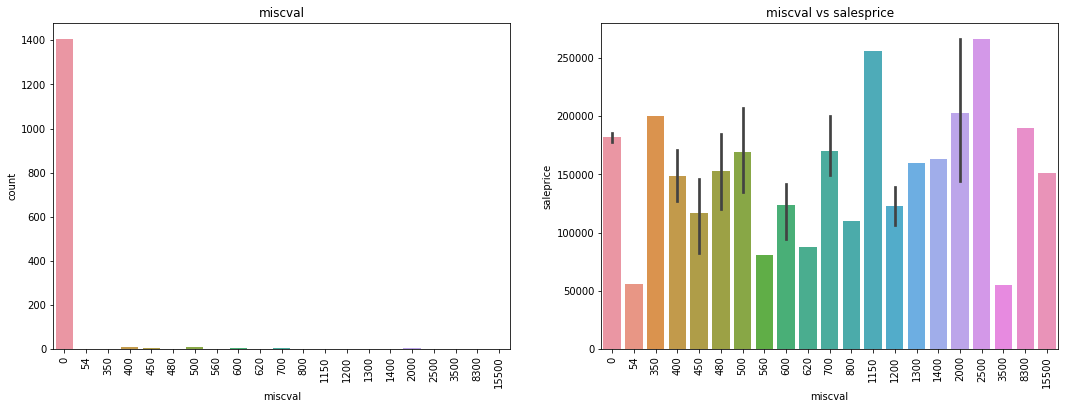

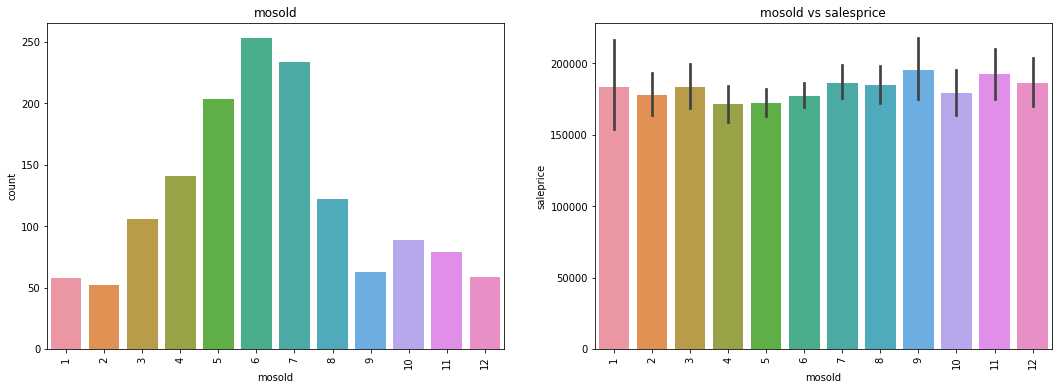

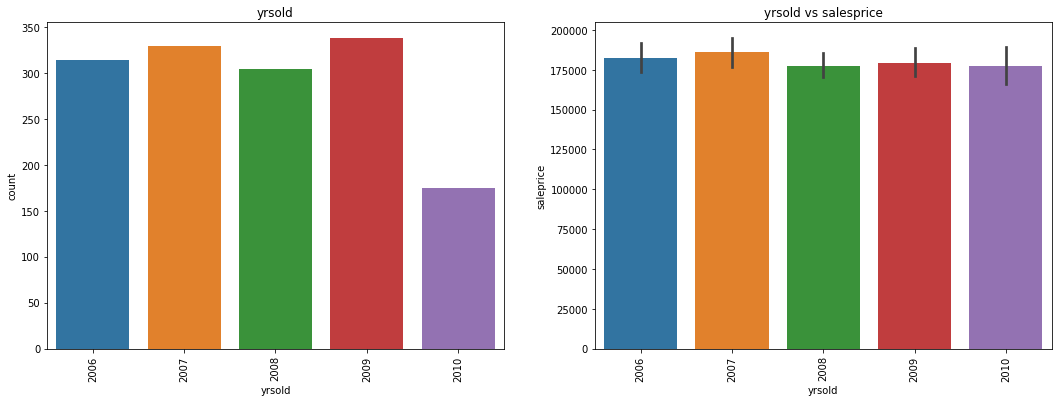

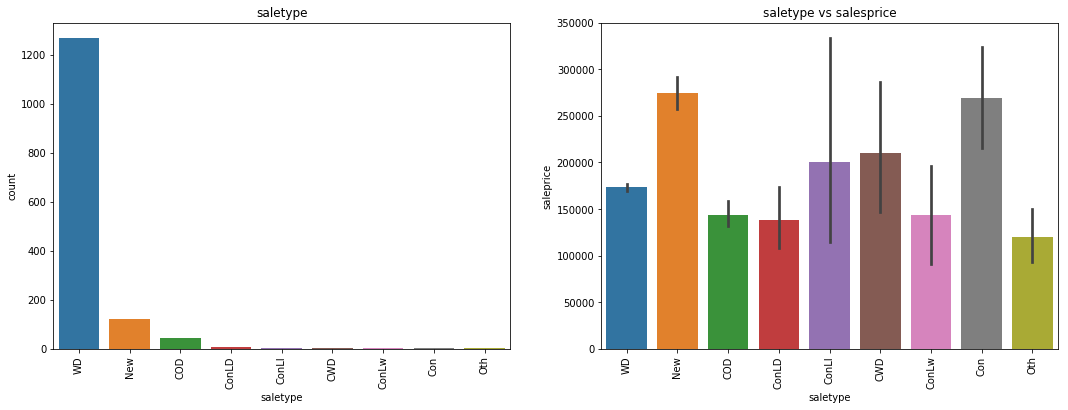

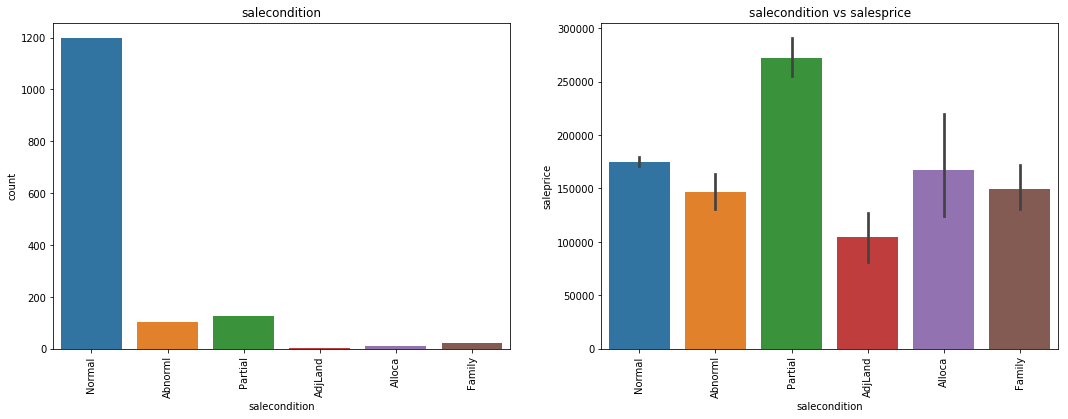

In [24]:
#let's inspect our categorical values
for column in cat_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(df[column])
    plt.title('{}'.format(column))
    plt.xticks(rotation='vertical')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=column, y='saleprice', data=df)
    plt.title('{} vs salesprice'.format(column))
    plt.xticks(rotation='vertical')
    
    plt.show()

After reviewing these, we'll start with a feature set of:
 - totrmsabvgrd
 - fireplaces
 - overallqual
 - garagecars
 - mszoning (dummies required)
 - kitchenqual (dummies required)

In [25]:
features = ['totrmsabvgrd', 'fireplaces', 'overallqual', 'garagecars']

Ok, let's look at some of our more continuous features. Ideally, we want a high correlation without much variability.

The coefficient is 0.33477085313975996


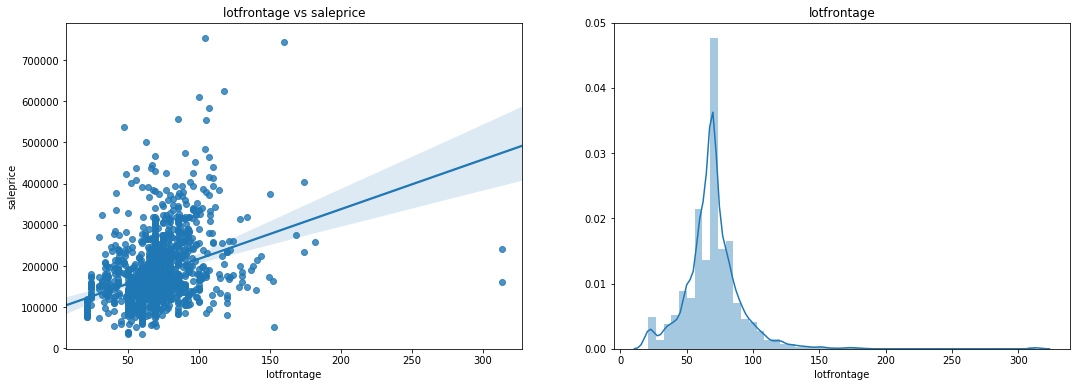

The coefficient is 0.2638433538714056


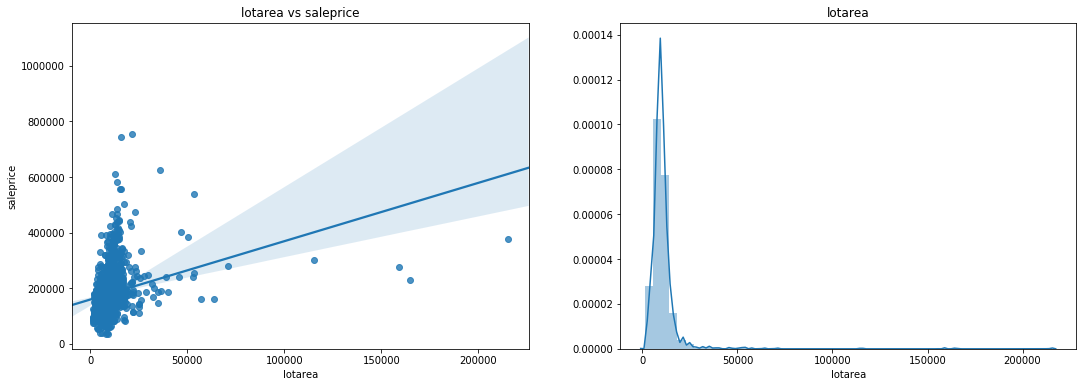

The coefficient is 0.522897332879497


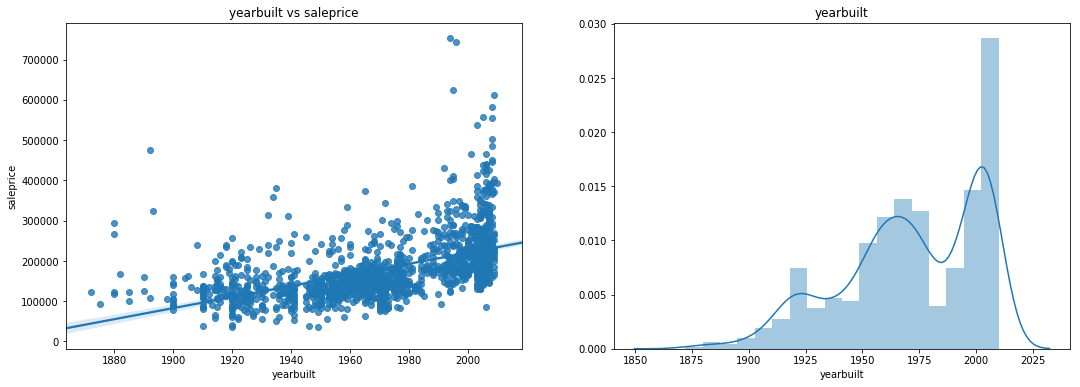

The coefficient is 0.5071009671113861


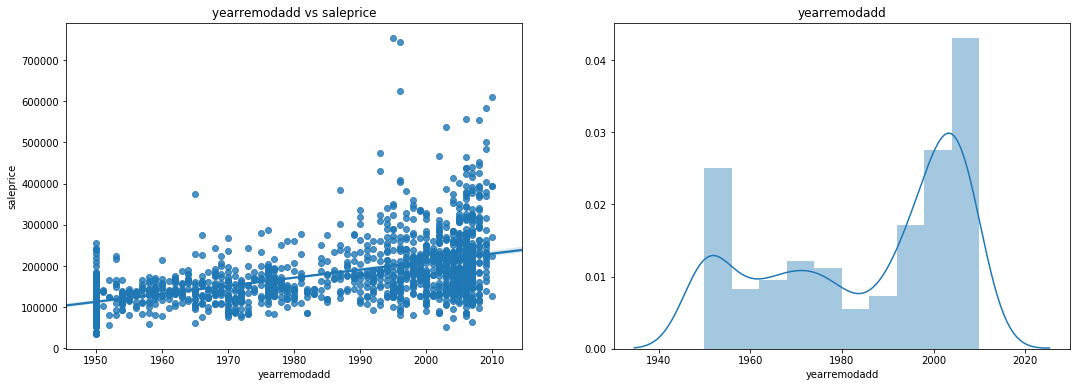

The coefficient is 0.4726144990045737


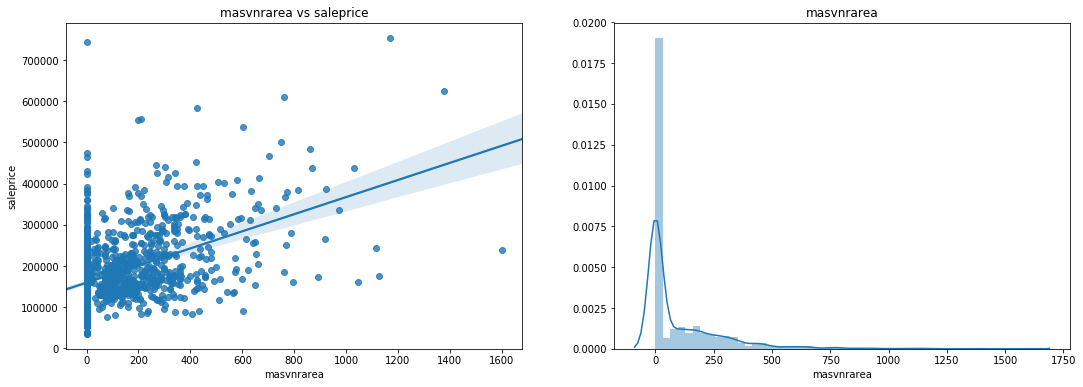

The coefficient is 0.3864198062421533


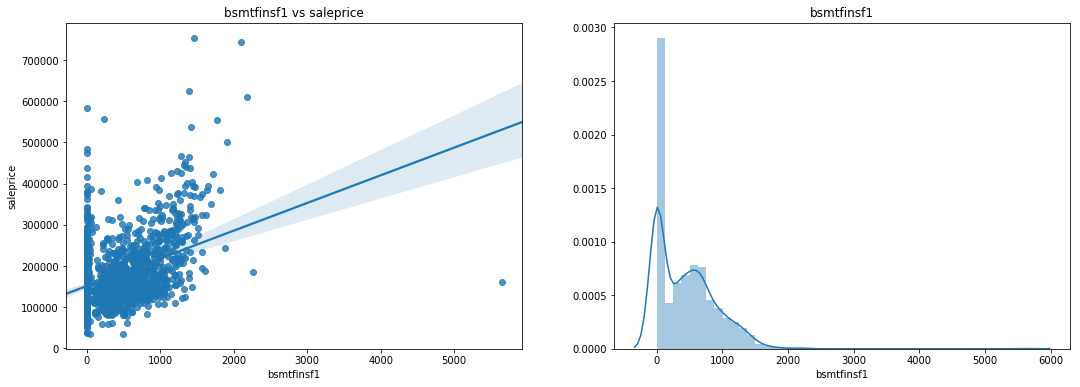

The coefficient is -0.01137812145021514


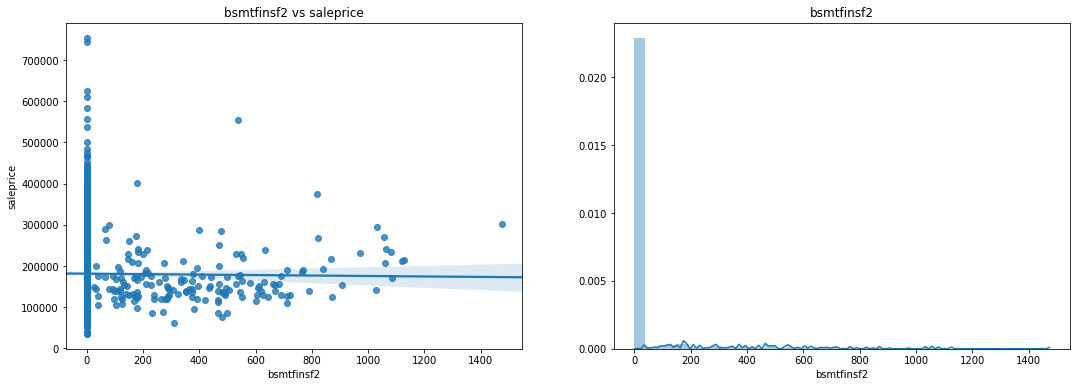

The coefficient is 0.2144791055469689


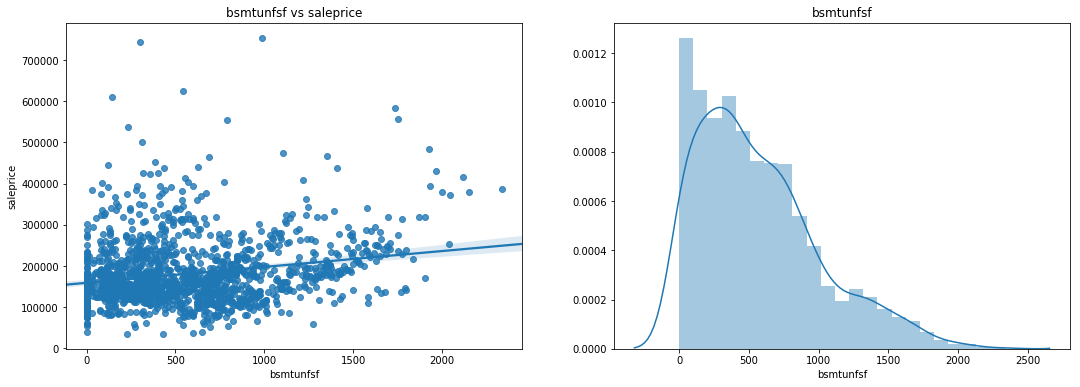

The coefficient is 0.6135805515591953


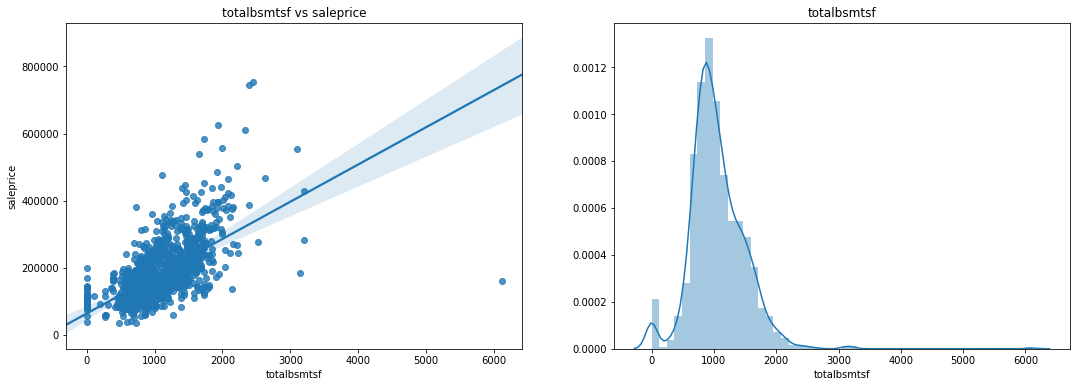

The coefficient is 0.6058521846919147


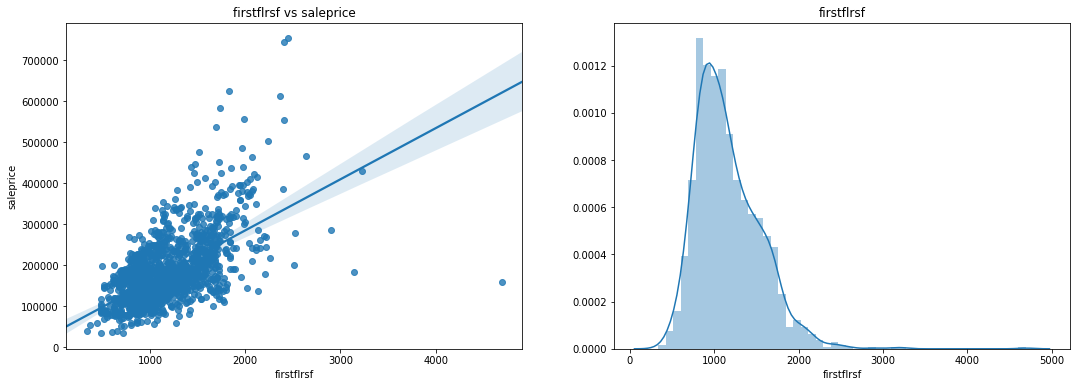

The coefficient is 0.3193338028320678


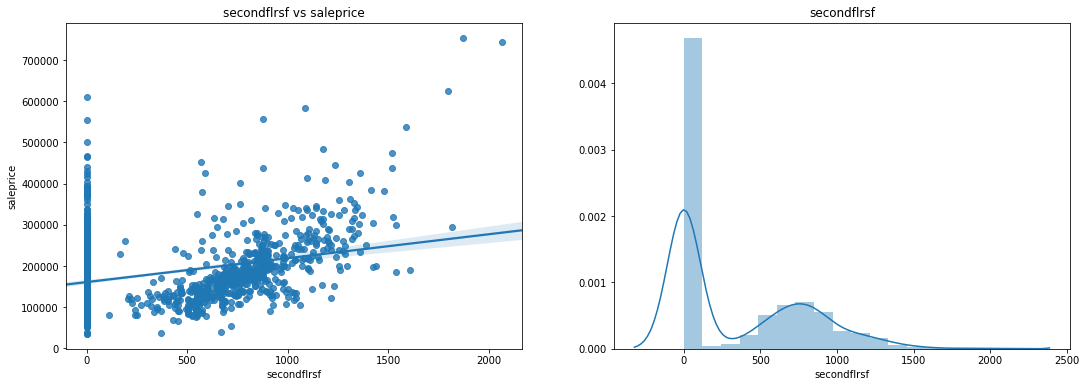

The coefficient is 0.708624477612652


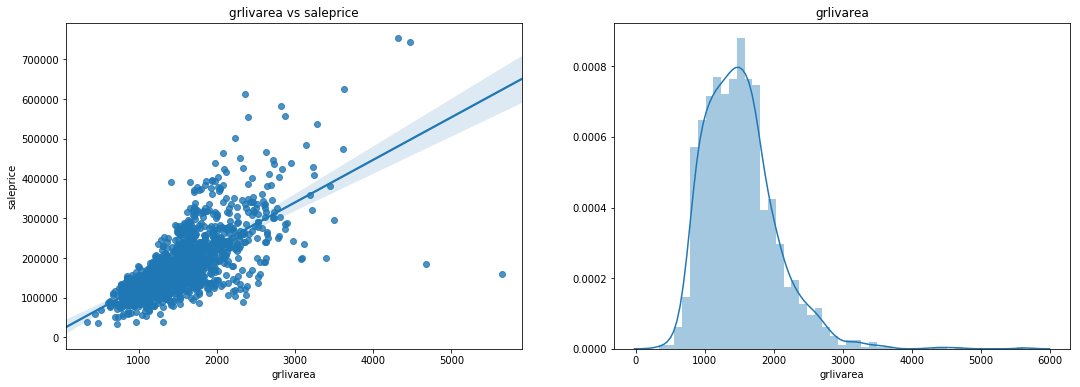

The coefficient is 0.6234314389183616


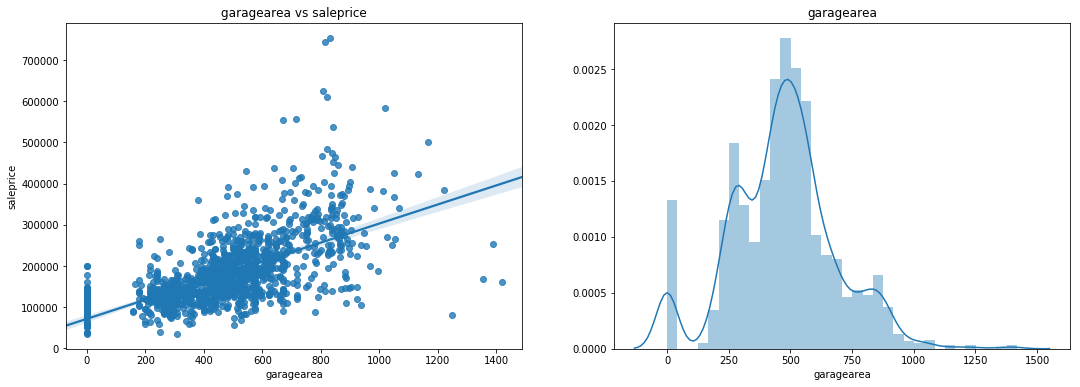

The coefficient is 0.3244134445681299


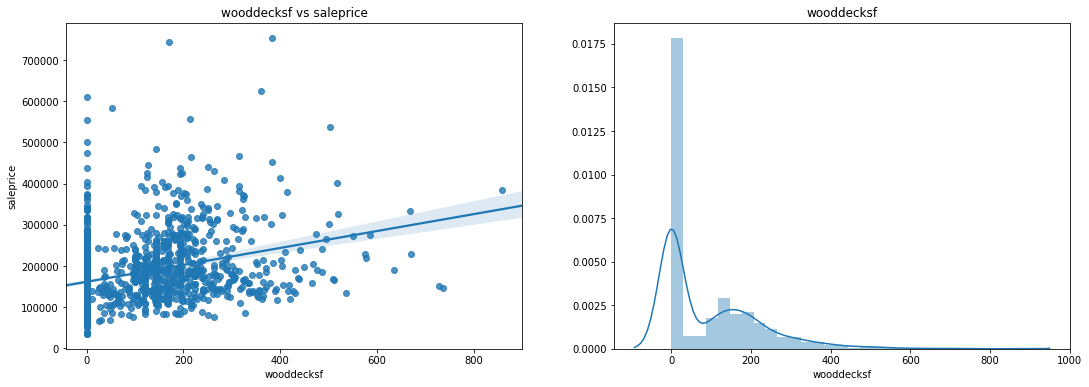

The coefficient is 0.3158562271160552


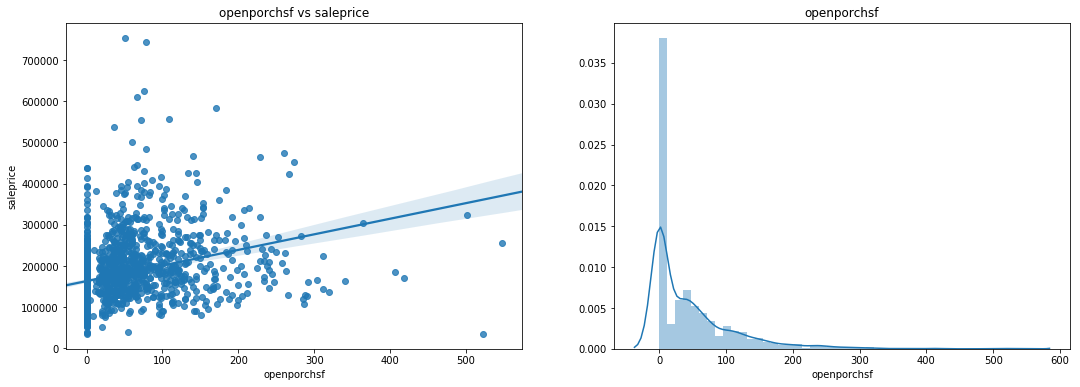

The coefficient is -0.12857795792595675


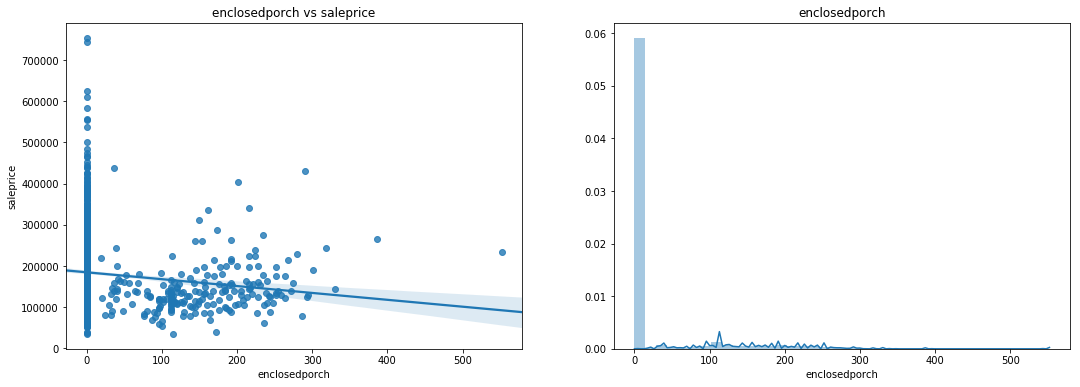

The coefficient is 1.0


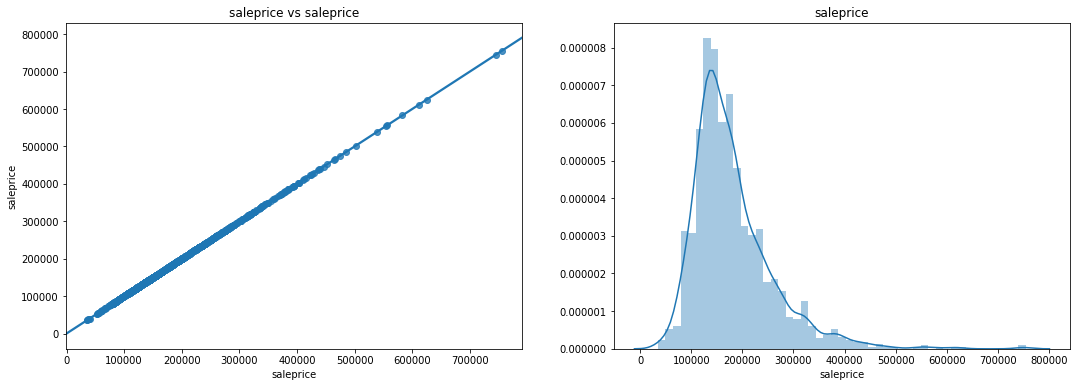

The coefficient is 0.11144657114291123


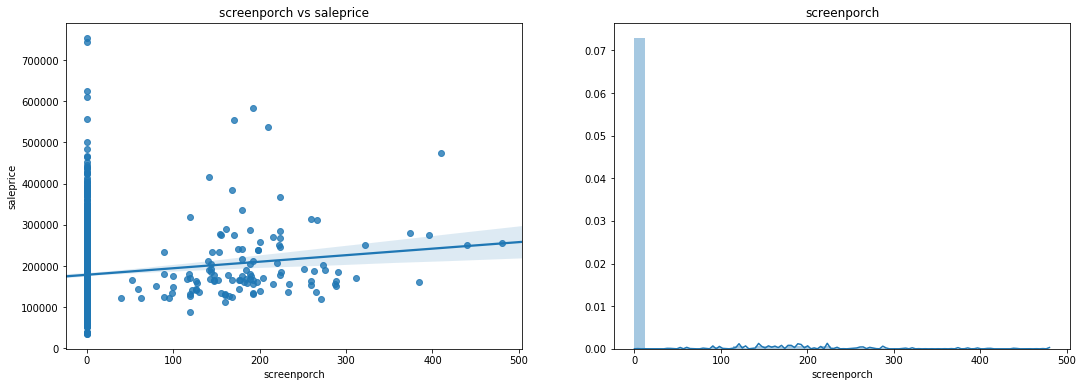

In [26]:
for column in cont_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    corr, p_value = stats.pearsonr(df['saleprice'], df[column])
    print('The coefficient is {}'.format(corr))
    sns.regplot(x=column, y='saleprice', data=df)
    plt.title('{} vs saleprice'.format(column))
    
    plt.subplot(1, 2, 2)
    sns.distplot(df[column])
    plt.title('{}'.format(column))
    
    plt.show()

In [27]:
#let's pick our best and add it to the features list - CAREFUL ONLY RUN ONCE!
features = features + ['grlivarea', 'totalbsmtsf', 'firstflrsf']

We've picked our initial features. Let's put them together and then see how they correlate with one another. We'll drop features that have too strong of features.

In [ ]:
#create three mini df's to add to our X df
cont_features = df[features]
zoning_dummies = pd.get_dummies(df['mszoning'], drop_first=True)
kitchen_dummies = pd.get_dummies(df['kitchenqual'], drop_first=True)

X = pd.concat([cont_features, zoning_dummies, kitchen_dummies], axis=1)
y = df['saleprice']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [30]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     308.2
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:                -13928.
No. Observations:                1168   AIC:                         2.789e+04
Df Residuals:                    1153   BIC:                         2.796e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.572e+04   1.72e+04     -1.496   

Our training data is set-up.At a glance, we have some varying amounts in our coefficients. They all seem to make sense, except that totrmsabvgrd is a negative number.

Let's see how well this model does with our test data.

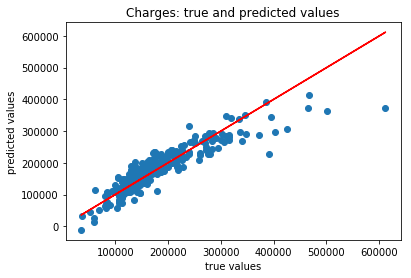

Mean absolute error of the prediction is: 22509.074372829793
Mean squared error of the prediction is: 1116641213.046946
Root mean squared error of the prediction is: 33416.18190408572
Mean absolute percentage error of the prediction is: 13.517970780117409


In [31]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

It seems the model is having a hard time predicting the larger values. We also had on feature that had a high p_value. Let's see how our model performs once we remove totrmsabvgrd and firstflrsf.

# Without totrmsabvgrd

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['totrmsabvgrd']), y, test_size=0.2, random_state=10)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [33]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     331.4
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:00:23   Log-Likelihood:                -13929.
No. Observations:                1168   AIC:                         2.789e+04
Df Residuals:                    1154   BIC:                         2.796e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.079e+04   1.69e+04     -1.826      

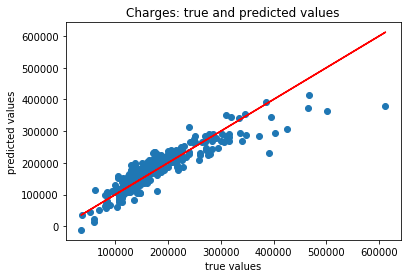

Mean absolute error of the prediction is: 22450.139805297604
Mean squared error of the prediction is: 1109212890.7021873
Root mean squared error of the prediction is: 33304.847855863074
Mean absolute percentage error of the prediction is: 13.466034074267652


In [34]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

# Without firstslrsf

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['firstflrsf']), y, test_size=0.2, random_state=10)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [36]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     332.2
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:00:24   Log-Likelihood:                -13928.
No. Observations:                1168   AIC:                         2.788e+04
Df Residuals:                    1154   BIC:                         2.796e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.549e+04   1.71e+04     -1.490   

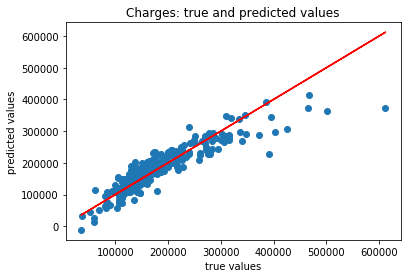

Mean absolute error of the prediction is: 22508.656343435072
Mean squared error of the prediction is: 1117006541.2343566
Root mean squared error of the prediction is: 33421.647793523836
Mean absolute percentage error of the prediction is: 13.515835773677164


In [37]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

# Without both totrmsabvgrd and firstflrsf

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['firstflrsf', 'totrmsabvgrd']), y, test_size=0.2, random_state=10)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [39]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     359.3
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:00:24   Log-Likelihood:                -13929.
No. Observations:                1168   AIC:                         2.788e+04
Df Residuals:                    1155   BIC:                         2.795e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.053e+04   1.68e+04     -1.819      

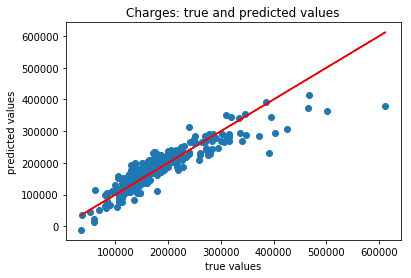

Mean absolute error of the prediction is: 22451.245058109376
Mean squared error of the prediction is: 1109610574.405791
Root mean squared error of the prediction is: 33310.817678432795
Mean absolute percentage error of the prediction is: 13.464426637815228


In [40]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Dropping these barely changes the model or causes it to perform a little worse.

What other features could we use/introduce that could improve our model.

## __New feature - including the bathrooms__

In [41]:
df['total_bath'] = df['bsmtfullbath'] + df['fullbath'] + (df['bsmthalfbath'] * 0.5) + (df['halfbath'] * 0.5)

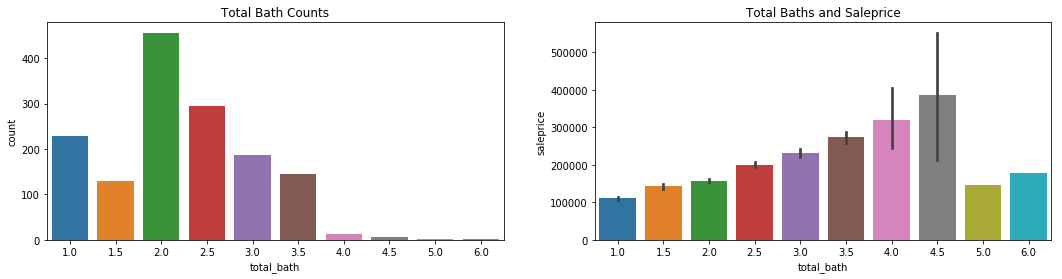

In [42]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
sns.countplot(df['total_bath'])
plt.title('Total Bath Counts')

plt.subplot(1, 2, 2)
sns.barplot(x='total_bath', y='saleprice', data=df)
plt.title('Total Baths and Saleprice')
plt.show()

This is an interesting feature. It seems like what we would expect until the 5/6 total_bath range. This could be caused by homes for rent that are sub-divided into different areas.

Let's add it to our model and see how it performs.

In [43]:
X = pd.concat([X, df['total_bath']], axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [45]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     296.7
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:00:25   Log-Likelihood:                -13913.
No. Observations:                1168   AIC:                         2.786e+04
Df Residuals:                    1152   BIC:                         2.794e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.183e+04    1.7e+04     -1.870   

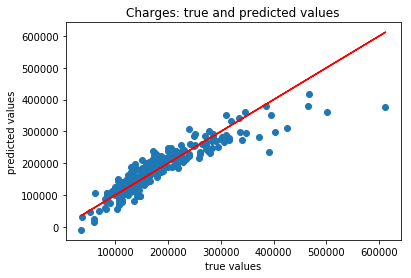

Mean absolute error of the prediction is: 22200.52609546404
Mean squared error of the prediction is: 1065429852.8693551
Root mean squared error of the prediction is: 32640.922978208735
Mean absolute percentage error of the prediction is: 13.311647554996705


In [46]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

This improved slightly. Let's see what happens when we drop our non-sig figures.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['totrmsabvgrd', 'firstflrsf', 'RH', 'RM']), y, test_size=0.2, random_state=10)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [48]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     403.7
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:00:25   Log-Likelihood:                -13916.
No. Observations:                1168   AIC:                         2.786e+04
Df Residuals:                    1156   BIC:                         2.792e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.557e+04   9857.737     -1.579      

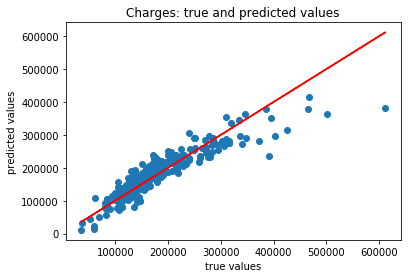

Mean absolute error of the prediction is: 22045.201978417976
Mean squared error of the prediction is: 1052158468.6284263
Root mean squared error of the prediction is: 32436.992287023568
Mean absolute percentage error of the prediction is: 12.983050562954185


In [49]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Ok! There is some definite improvement. Let's pause with this set of features and try some regularization.

# __Ridge Regression__

For our regularization, we're going to use almost all of the original features.

In [50]:
X = pd.DataFrame()

In [51]:
cat_cols.remove('mssubclass')
cont_cols.remove('saleprice')

In [52]:
#create dummy features
for column in cat_cols:
    X = pd.concat([X, pd.get_dummies(df[column], drop_first=True)], axis=1)
#create continuous features
for column in cont_cols:
    X = pd.concat([X, df[column]], axis=1)

In [53]:
#let's tune our hyperparameter
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

averages = []
#let's tune our alpha by finding the most consistent measure via cross validation
for i in range(1, 100):
    ridgeregr = Ridge(alpha=10**i) 
    averages.append(cross_val_score(ridgeregr, X, y, cv=10, scoring='neg_mean_squared_error').mean())
    
print('Highest mean: {} -- Parameter: {}'.format(max(averages), averages.index(max(averages)) + 1))

Highest mean: -1031246087.6833032 -- Parameter: 1


In [54]:
#reload our train/testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [55]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10*1) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.9110444875659955
-----Test set statistics-----
R-squared of the model on the test set is: 0.8831983626022631
Mean absolute error of the prediction is: 17886.309283718645
Mean squared error of the prediction is: 726685735.0715462
Root mean squared error of the prediction is: 26957.10917497546
Mean absolute percentage error of the prediction is: 10.917004596093898


# __Lasso Regression__

In [56]:
from sklearn.linear_model import Lasso

averages = []
for i in range(1, 100):
    lassoregr = Lasso(alpha=10**i) 
    averages.append(cross_val_score(lassoregr, X, y, scoring='neg_mean_squared_error', cv=10).mean())

print('Highest mean: {} -- Parameter: {}'.format(max(averages), averages.index(max(averages)) + 1))

Highest mean: -989404435.6349669 -- Parameter: 2


In [57]:
#reload our train/testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))\

The number of observations in training set is 1168
The number of observations in test set is 292


In [58]:
# Fitting a lasso regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
lassoregr = Lasso(alpha=10**2) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.9284040803023864
-----Test set statistics-----
R-squared of the model on the test set is: 0.9027398536475297
Mean absolute error of the prediction is: 17886.309283718645
Mean squared error of the prediction is: 726685735.0715462
Root mean squared error of the prediction is: 26957.10917497546
Mean absolute percentage error of the prediction is: 10.917004596093898


# __Elastic Net__

In [60]:
from sklearn.linear_model import ElasticNet

#tune the alpha and l1
averages = []
items = []
l1 = []
for i in range(1, 100):
    for j in np.arange(0.1, 1.0, 0.1):
        elasticregr = ElasticNet(alpha=10**i ,l1_ratio=j) 
        averages.append(cross_val_score(elasticregr, X, y, scoring='neg_mean_squared_error', cv=10).mean())
        items.append(i)
        l1.append(j)

index = averages.index(max(averages))
print(max(averages), averages[index], items[index], l1[index])

-1507738195.6982987 -1507738195.6982987 1 0.9


In [61]:
elasticregr = ElasticNet(alpha=10**1, l1_ratio=0.9) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.7793786200502664
-----Test set statistics-----
R-squared of the model on the test set is: 0.8090655982938878
Mean absolute error of the prediction is: 22348.586079989363
Mean squared error of the prediction is: 1187905487.8467019
Root mean squared error of the prediction is: 34466.0048141165
Mean absolute percentage error of the prediction is: 12.89967346180004


Ok, well it looks like our ridge and lasso models perform the best! Even better than our original model. Good to know!

## Incorporate some real world data

I wanted to find the GDP of Iowa for all the potential year, however I couldn't find the information.

I did find the US GDP for varying years. https://fred.stlouisfed.org/series/GDP

In [71]:
gdp_df = pd.read_csv('GDP.csv')
gdp_df.head()

,DATE,GDP,YEAR
0,1/1/1947,243.164,1947
1,4/1/1947,245.968,1947
2,7/1/1947,249.585,1947
3,10/1/1947,259.745,1947
4,1/1/1948,265.742,1948


In [72]:
#load the data
yearly_gdp = gdp_df.groupby('YEAR')['GDP'].mean().reset_index()
yearly_gdp.head()

#create a dictionary of all the years
gdp_dict = {}

for i in range(len(yearly_gdp)):
    gdp_dict.update( {yearly_gdp.YEAR[i] : yearly_gdp.GDP[i] } )

In [73]:
#create a list of all the gdp's by year
lst = []
for year in df.yearbuilt:
    if year in gdp_dict:
        lst.append(gdp_dict[year])
    else:
        lst.append(np.nan)

#add the list to the df
df['gdp'] = lst

In [74]:
df.gdp.fillna(df.gdp.median(), inplace=True)

The coefficient is 0.5462238934528415


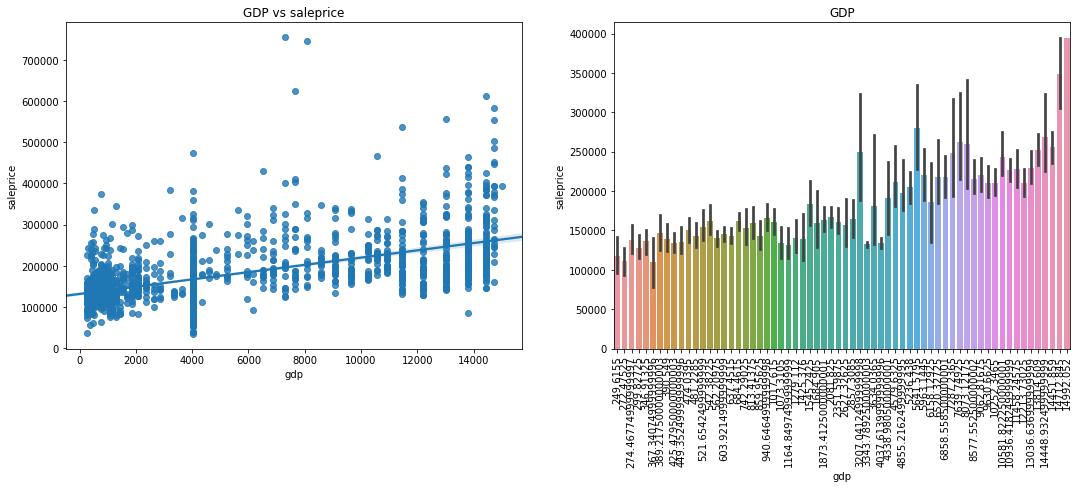

In [75]:
plt.figure(figsize=(18, 6))
    
plt.subplot(1, 2, 1)
corr, p_value = stats.pearsonr(df['saleprice'], df.gdp)
print('The coefficient is {}'.format(corr))
sns.regplot(x='gdp', y='saleprice', data=df)
plt.title('GDP vs saleprice')

plt.subplot(1, 2, 2)
sns.barplot(x='gdp', y='saleprice', data=df)
plt.xticks(rotation='vertical')
plt.title('GDP')

plt.show()

In [76]:
X = pd.concat([X, df['gdp']], axis=1)
X.head()

,FV,RH,RL,RM,Pave,No Access,Pave,IR2,IR3,Reg,HLS,Low,Lvl,NoSeWa,CulDSac,FR2,FR3,Inside,Mod,Sev,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNn,2fmCon,Duplex,Twnhs,TwnhsE,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,2,3,4,5,6,7,8,9,10,2,3,4,5,6,7,8,9,Gable,Gambrel,Hip,Mansard,Shed,CompShg,Membran,Metal,Roll,Tar&Grv,WdShake,WdShngl,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing,AsphShn,Brk Cmn,BrkFace,CBlock,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,Stone,Stucco,VinylSd,Wd Sdng,Wd Shng,BrkFace,No masonry,None,Stone,Fa,Gd,TA,Fa,Gd,Po,TA,CBlock,PConc,Slab,Stone,Wood,Fa,Gd,No Basement,TA,Gd,No Basement,Po,TA,Gd,Mn,No,No Basement,BLQ,GLQ,LwQ,No Basement,Rec,Unf,BLQ,GLQ,LwQ,No Basement,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Fa,Gd,Po,TA,Y,FuseF,FuseP,Mix,SBrkr,53,80,120,144,156,205,232,234,360,371,384,390,392,397,420,473,479,481,513,514,515,528,572,1,2,3,1,2,1,2,3,1,2,1,2,3,4,5,6,8,1,2,3,Fa,Gd,TA,3,4,5,6,7,8,9,10,11,12,14,Maj2,Min1,Min2,Mod,Sev,Typ,1,2,3,Fa,Gd,No Fireplace,Po,TA,Attchd,Basment,BuiltIn,CarPort,Detchd,No Garage,No Garage,RFn,Unf,1,2,3,4,Fa,Gd,No Garage,Po,TA,Fa,Gd,No Garage,Po,TA,P,Y,23,96,130,140,144,153,162,168,180,182,196,216,238,245,290,304,320,407,508,480,512,519,555,576,648,738,Fa,Gd,No pool,GdWo,MnPrv,MnWw,No Fence,None unique,Othr,Shed,TenC,54,350,400,450,480,500,560,600,620,700,800,1150,1200,1300,1400,2000,2500,3500,8300,15500,2,3,4,5,6,7,8,9,10,11,12,2007,2008,2009,2010,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial,lotfrontage,lotarea,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,grlivarea,garagearea,wooddecksf,openporchsf,enclosedporch,screenporch,gdp
0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,1710,548,0,61,0,0,11458.24575
1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,1262,460,298,0,0,0,1873.41250
2,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [78]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     48.21
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        20:47:45   Log-Likelihood:                -13064.
No. Observations:                1168   AIC:                         2.681e+04
Df Residuals:                     827   BIC:                         2.854e+04
Df Model:                         340                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.218e+05    8.1e+04     -3.972

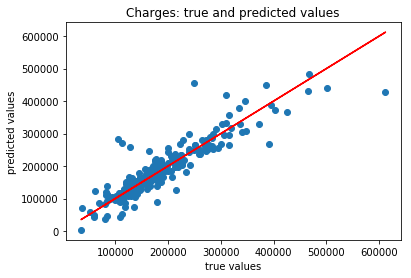

Mean absolute error of the prediction is: 20520.575748843672
Mean squared error of the prediction is: 1153611264.1279652
Root mean squared error of the prediction is: 33964.85336532406
Mean absolute percentage error of the prediction is: 12.817788574528146


In [79]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))